[Source](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) (Used only Default FGSM attack and test functions from this source)

# Import Libraries

In [1]:
from torch.utils.data import Dataset,DataLoader,random_split
from typing import Any,Tuple,Optional,Callable
import PIL
import csv
import pathlib
import torch
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torchvision.transforms import ToTensor,Resize,Compose,ColorJitter,RandomRotation,AugMix,RandomCrop,GaussianBlur,RandomEqualize,RandomHorizontalFlip,RandomVerticalFlip
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score
import tqdm
import torch.nn.functional as F
import random

### Select device to use

In [2]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

## GTSRB Dataset class

In [3]:
class GTSRB(Dataset):
    def __init__(self,
                 root: str,
                 split: str,
                 transform: Optional[Callable] = None):
       
        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split =='train' else 'Test.csv')
        
        with open(str(self.csv_file)) as csvfile:
           samples = [(str(self.base_folder / row['Path']),int(row['ClassId'])) 
            for row in csv.DictReader(csvfile,delimiter=',',skipinitialspace=True)
                ]

        self.samples = samples
        self.split = split
        self.transform = transform

    def __len__(self):        
        return len(self.samples)
    
    def __getitem__(self, index: int) -> Tuple:
        path,classId =  self.samples[index]
        sample = PIL.Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample,classId

## Load pretrained Model (98.9865% Accuracy)

In [4]:
class GTSRB_MODEL(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(GTSRB_MODEL,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.metrics = {}
        
        self.flatten = nn.Flatten()
        
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(1024)

        self.l1 = nn.Linear(1024*4*4,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_dim)
        
    def forward(self,input):
        
        conv = self.conv1(input)
        conv = self.conv2(conv)
        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)
        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool(batchnorm)
        
        flatten = self.flatten(maxpool)
        
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
        return output
    
    def training_metrics(self,positives,data_size,loss):
        acc = positives/data_size
        return loss,acc
    
    def validation_metrics(self,validation_data,loss_function):
       data_size = len(validation_data)
       correct_predictions = 0
       total_samples = 0
       val_loss = 0

       model = self.eval()
       with torch.no_grad() : 
        for step,(input,label) in enumerate(validation_data):
            input,label = input.to(device),label.to(device)
            prediction = model.forward(input)
            loss = loss_function(prediction,label)
            val_loss = loss.item()
            _,predicted = torch.max(prediction,1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

       val_acc = correct_predictions/total_samples

       return val_loss,val_acc

    def history(self):
        return self.metrics

    def compile(self,train_data,validation_data,epochs,loss_function,optimizer,learning_rate_scheduler):
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('training started ...')
        STEPS = len(train_data)
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step,(input,label) in enumerate(train_loader):

                    input,label = input.to(device),label.to(device)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == label).sum().item()
                    total_examples += label.size(0)
                    l = loss_function(prediction,label)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'green'
                    progress.desc = f'Epoch [{epoch}/{EPOCHS}], Step [{step}/{STEPS}], Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}], Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]'
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')

            
            learning_rate_scheduler.step()
        
        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('training complete !')    

In [5]:
f = open('gstrb-99-saved_model.pkl','rb')
model = pickle.load(f)
f.close()

model.to(device)
model.eval()

GTSRB_MODEL(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_fe

In [6]:
transforms = Compose([
    Resize([50,50]),
    ToTensor(),
])

testdata = GTSRB(root='./dataset',split='test',transform=transforms)
print('testing size :',len(testdata))
test_dataloader = DataLoader(testdata)

testing size : 12630


## Test accuracy on original dataset

In [7]:
y_pred = []
y_true = []
model = model.eval().to(device)
with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
  
  with torch.no_grad() : 
    for id,(input,label) in enumerate(iter(test_dataloader)):
        input,label = input.to(device),label.to(device)
        y_true.append(label.item())
        prediction = model.forward(input)
        _,prediction = torch.max(prediction,1)
        y_pred.append(prediction.item())
        
        progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
        progress.update(1)

Test Accuracy : 0.9898653998416469 : 100%|█| 12630/12630 [01:


## FGSM Attack Functions

In [8]:
def fgsm_attack_linf(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    s_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*s_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [9]:
def fgsm_attack_l2(image, epsilon, data_grad):
    # Collect the unit vector of data gradient
    normalized_data_grad = data_grad / data_grad.norm()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*normalized_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

### Result generation function

In [10]:
result_idx = random.sample(range(0, len(testdata)-1), 10)
def generate_results(epsilons,model,dataset_gen_fn,testdata,save_loc = None,fn_args = {},dist_fn = None,show_results = True):
    adversarial_data = {}
    accuracies = {}

    test_dataloader = DataLoader(testdata)
    
    for e in epsilons:
        adv_data = dataset_gen_fn(model, device, test_dataloader, e,**fn_args)
        perturbed_test_dataloader = DataLoader(adv_data)
    
        y_pred = []
        y_true = []
        model = model.eval().to(device)
        with tqdm.tqdm(colour='red',total=len(perturbed_test_dataloader)) as progress:
          
          with torch.no_grad() : 
            for input,label in iter(perturbed_test_dataloader):
                input,label = input.to(device),label.to(device)
                y_true.append(label.item())
                prediction = model.forward(input)
                _,prediction = torch.max(prediction,1)
                y_pred.append(prediction.item())
                
                progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
                progress.update(1)
        adversarial_data[e] = adv_data
        accuracies[e] = accuracy_score(y_true,y_pred)
        if show_results:
            fig, ax = plt.subplots(2, len(result_idx), figsize = (30, 8))
            if 'num_epochs' in fn_args:
                fig.suptitle(f"Num Epochs: {fn_args['num_epochs']}, Epsilon: {e}, Accuracy: {accuracies[e]*100:.3f} %",size=30, fontweight='bold')
            else:
                fig.suptitle(f"Epsilon: {e}, Accuracy: {accuracies[e]*100:.3f} %",size=30, fontweight='bold')
            plt.subplots_adjust(bottom=4,top=5)
            fig.tight_layout()
            for i in range(len(result_idx)):
                idx = result_idx[i]
                ax[0, i].imshow(torch.swapaxes(testdata[idx][0],0,1).swapaxes(1,2))
                ax[0, i].axis("off")
                prediction = model.forward(testdata[idx][0][None,:,:,:].to(device))
                ax[0, i].set_title(f"Pred:     {torch.max(prediction,1)[1].cpu().item()}\nConfi: {torch.nn.functional.softmax(prediction,dim=1).max().item():.3f}", size = 20, y=-0.3)
                ax[1, i].imshow(adv_data[idx][0].swapaxes(0,1).swapaxes(1,2))
                
                prediction = model.forward(adv_data[idx][0][None,:,:,:].to(device))
                distance = ''
                if dist_fn:
                    distance = f'\nDist: {dist_fn(testdata[idx][0],adv_data[idx][0]):.3f}'
                ax[1, i].set_title(f"Pred:     {torch.max(prediction,1)[1].cpu().item()}\nConfi: {torch.nn.functional.softmax(prediction,dim=1).max().item():.3f}"+distance, size = 20, y=-0.3 - 0.2*(dist_fn!=None))
                ax[1, i].axis("off")
            plt.show()
        save_loc = f"./pkl/{e}_{dataset_gen_fn.__name__}_{str(fn_args)}.pkl"
        with open(save_loc,'wb') as output_file:
            pickle.dump(adv_data,output_file)

    return accuracies

## Default FGSM

Progress: 100%|████████| 12630/12630 [02:32<00:00, 82.90it/s]
Test Accuracy : 0.6357086302454473 : 100%|█| 12630/12630 [01:


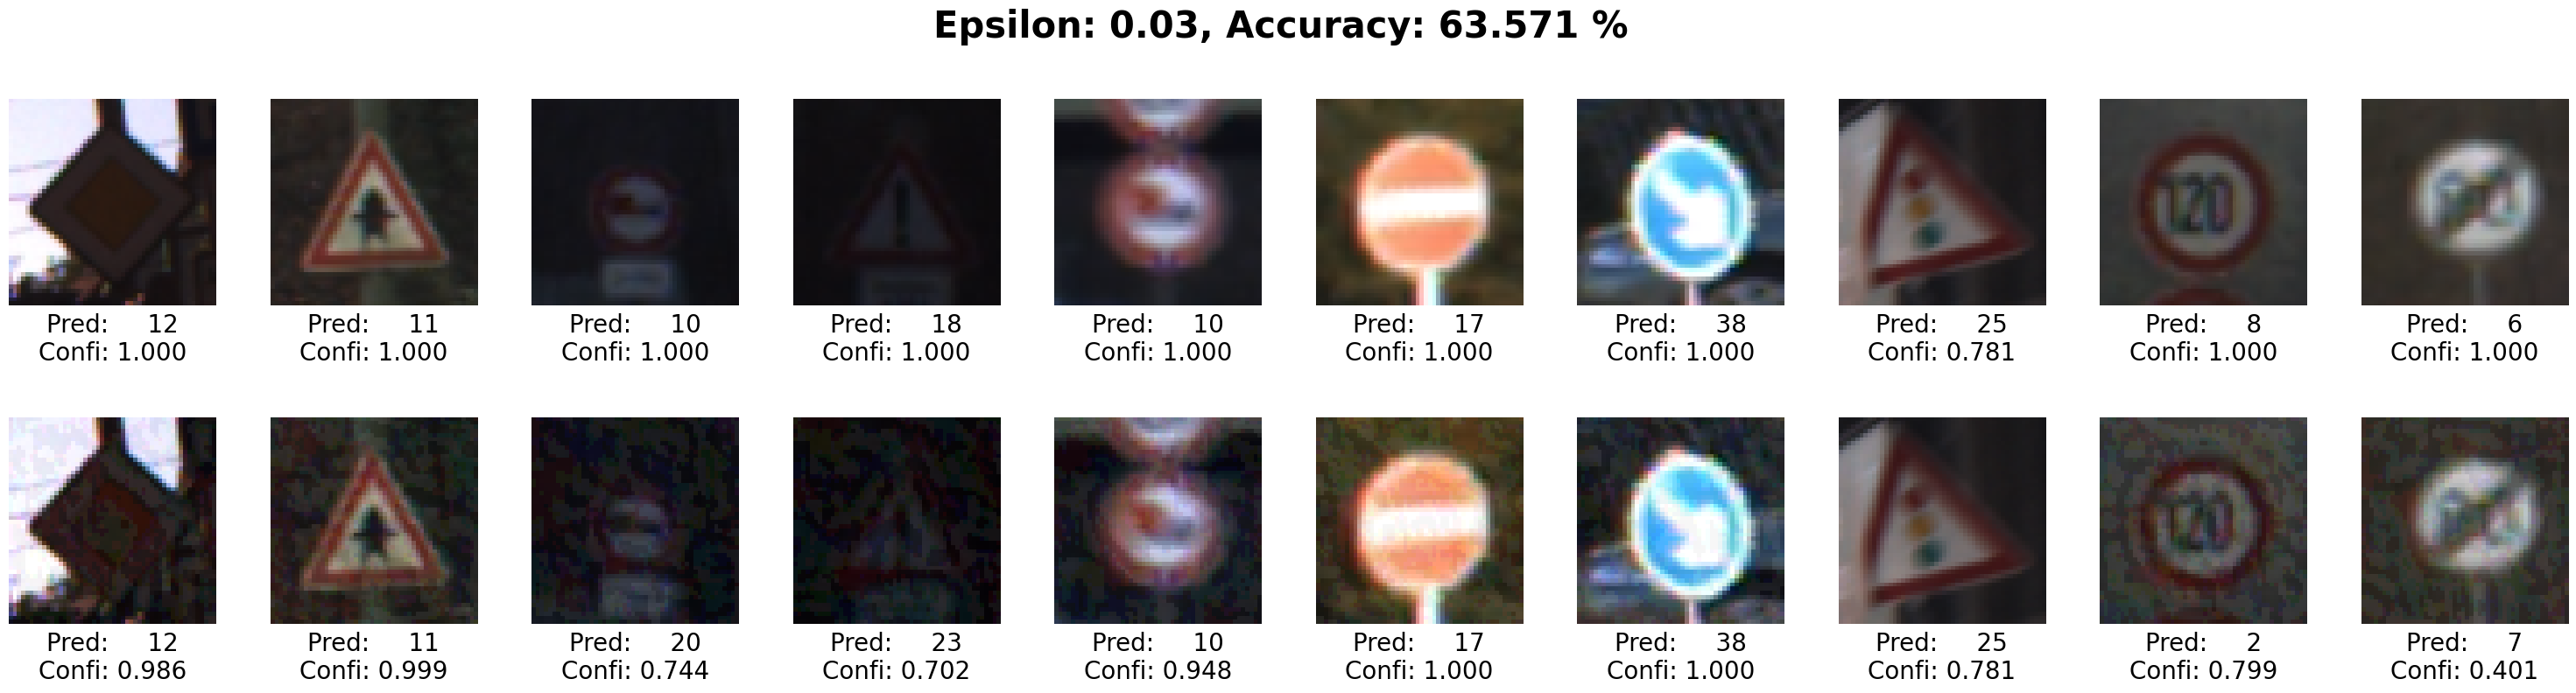

Progress: 100%|████████| 12630/12630 [02:33<00:00, 82.29it/s]
Test Accuracy : 0.49778305621536023 : 100%|█| 12630/12630 [01


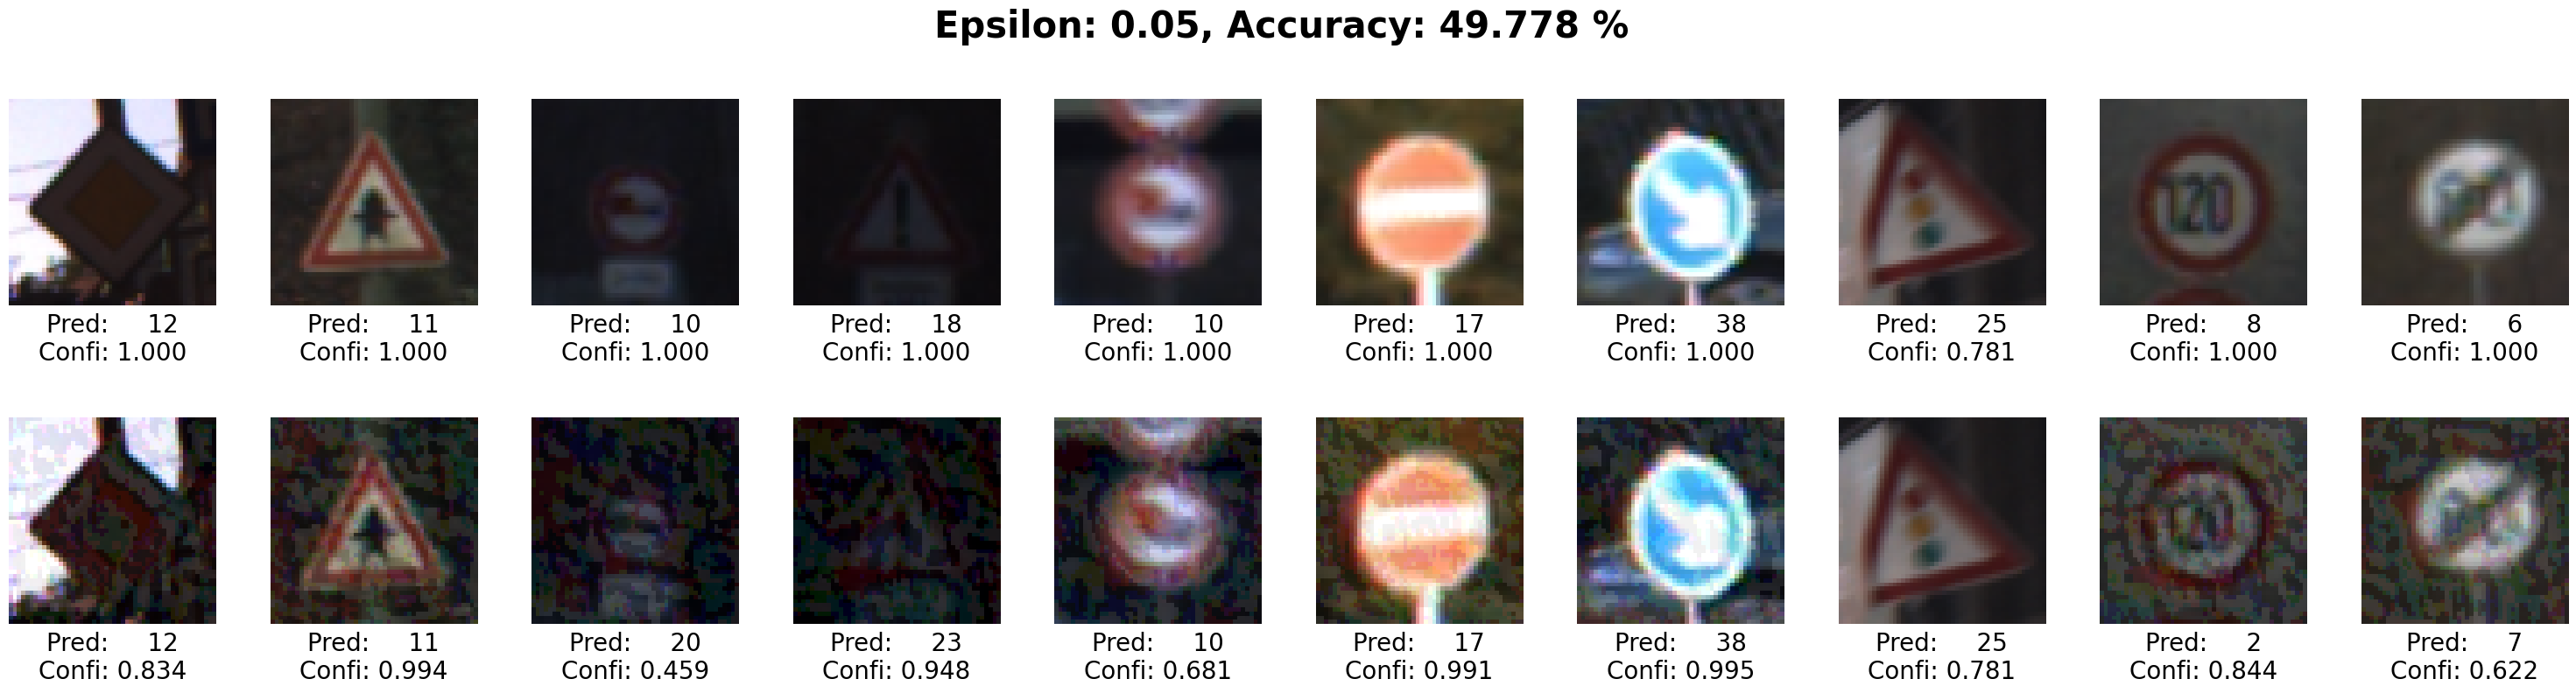

Progress: 100%|████████| 12630/12630 [02:37<00:00, 80.23it/s]
Test Accuracy : 0.4123515439429929 : 100%|█| 12630/12630 [01:


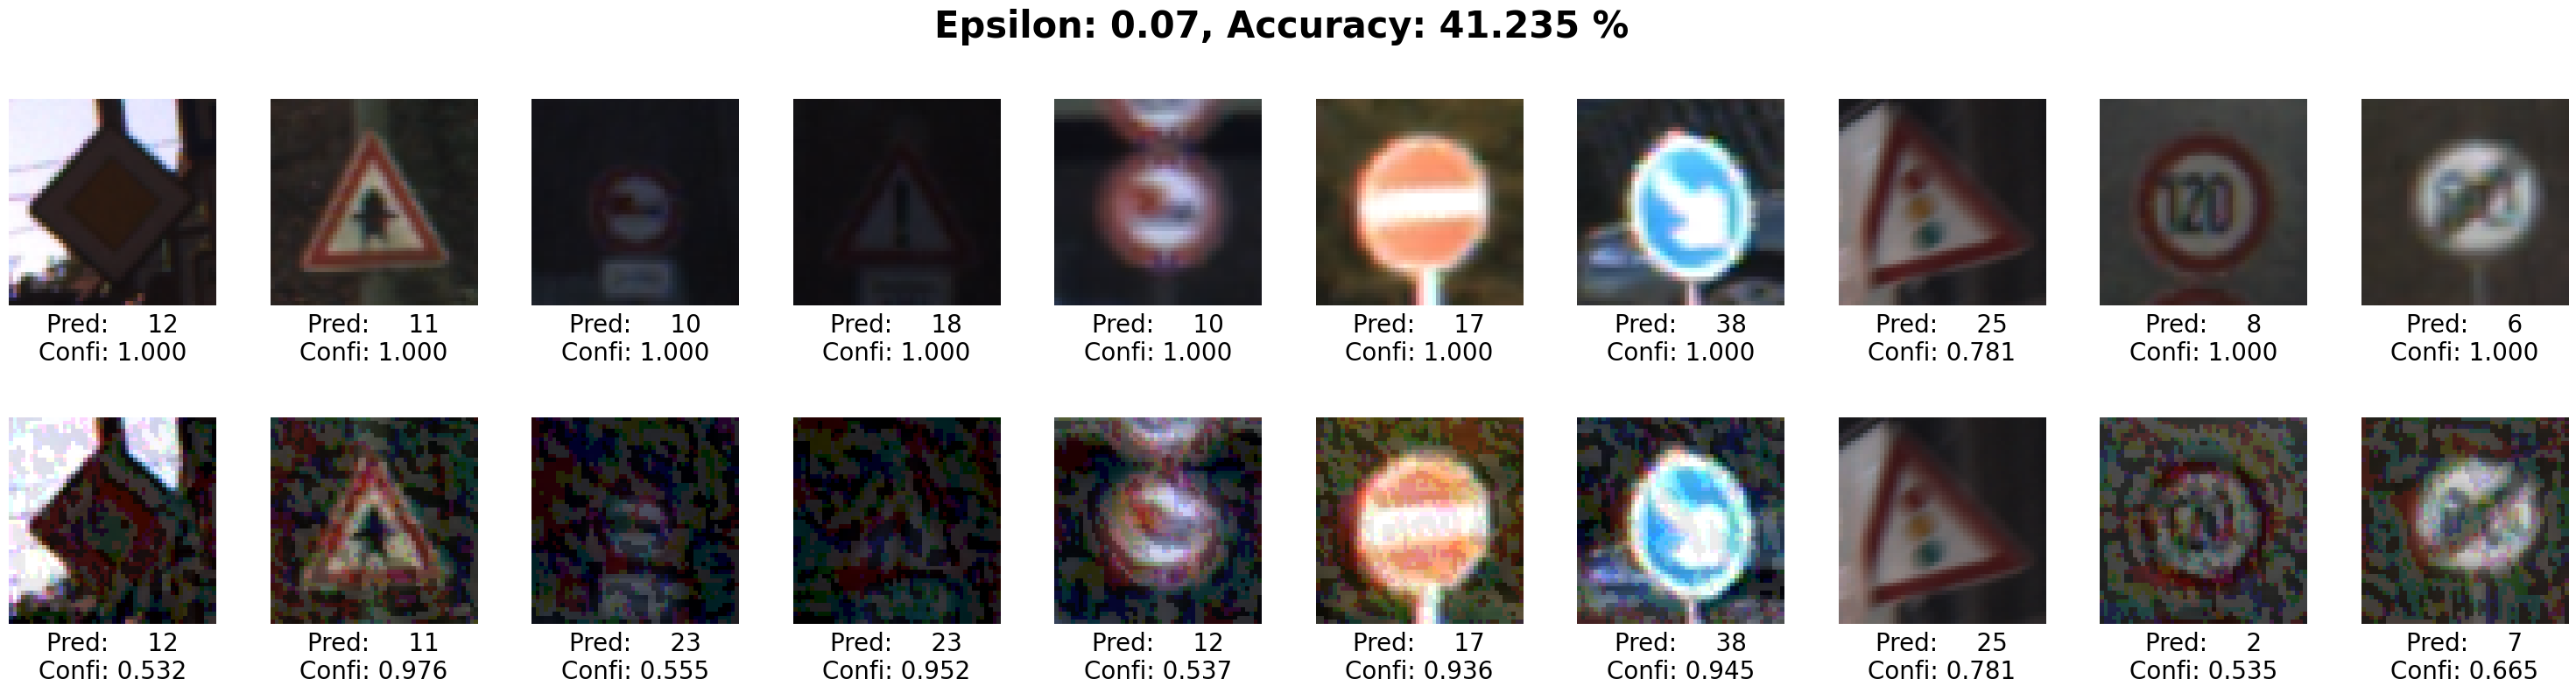

Progress: 100%|████████| 12630/12630 [02:32<00:00, 82.57it/s]
Test Accuracy : 0.3269200316706255 : 100%|█| 12630/12630 [01:


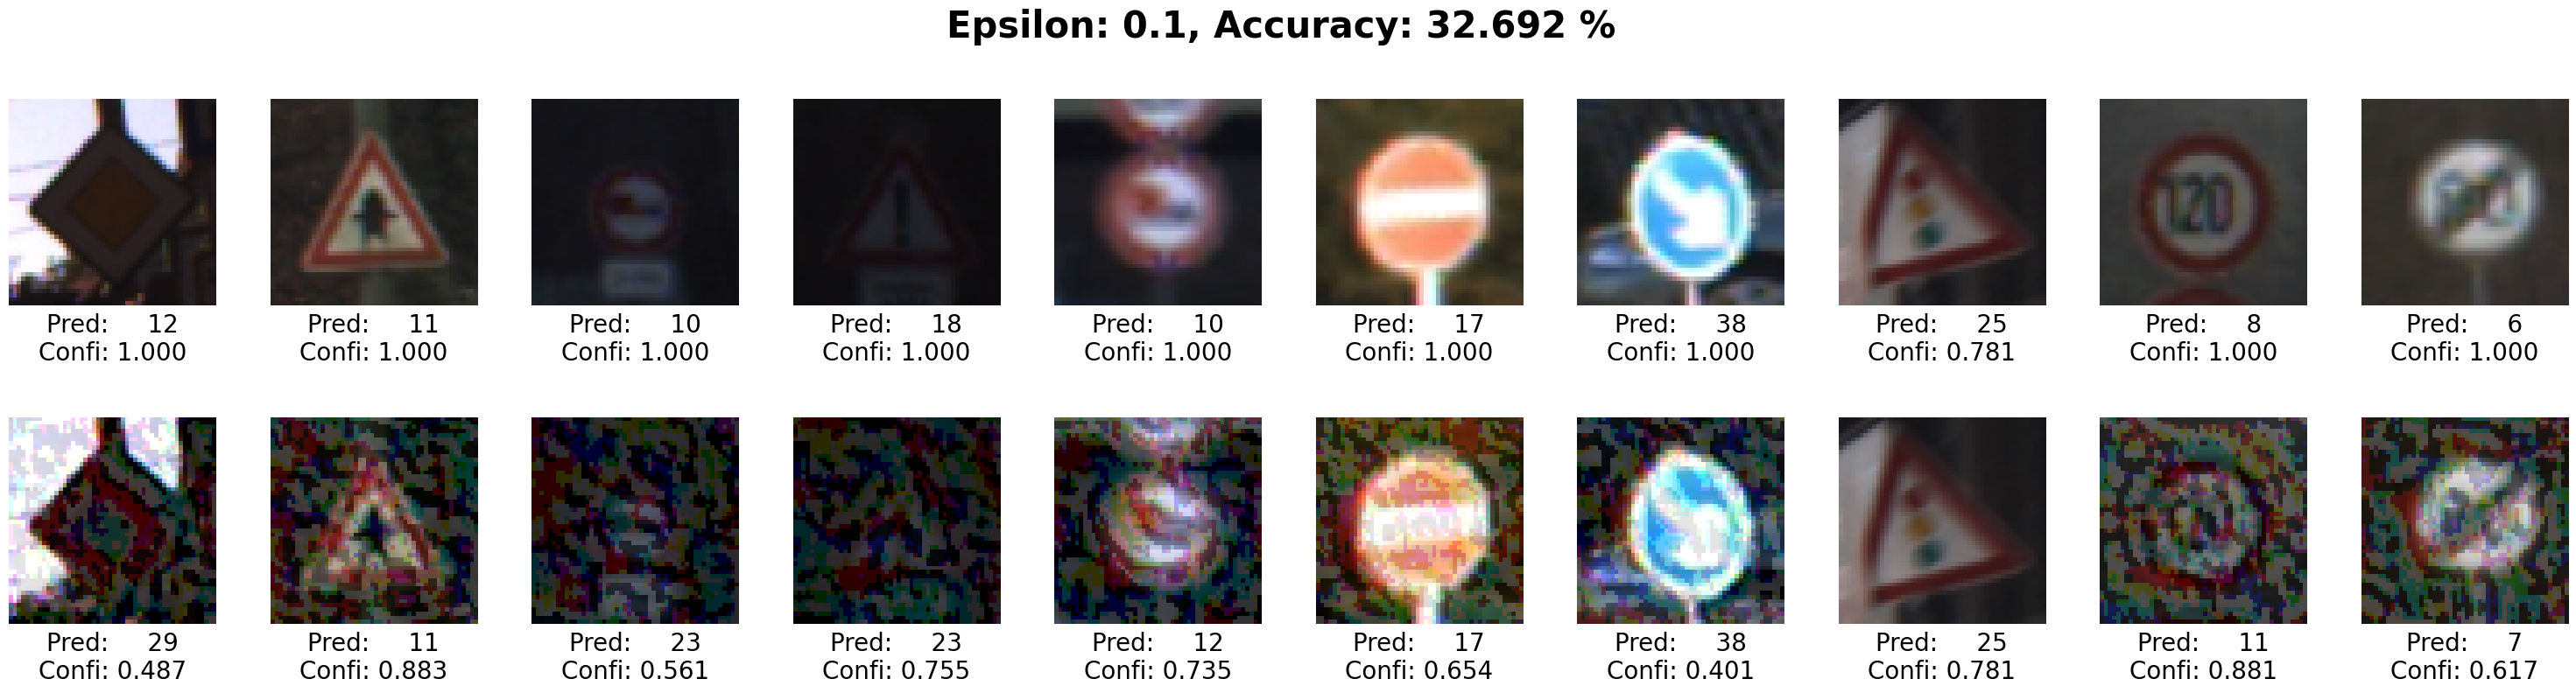

In [11]:
def generate_adversarial_dataset_fgsm_default(model, device, test_loader, epsilon):
    adv_examples = []

    with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
        # Loop over all examples in test set
        for data, target in test_loader:
            # Send the data and label to the device
            data, target = data.to(device), target.to(device)
            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True
            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            # If the initial prediction is wrong, don't bother attacking, just move on
            if init_pred.item() != target.item():
                adv_examples.append((data.squeeze().detach().cpu(), target))
                progress.update(1)
                continue
            # Calculate the loss
            loss = F.nll_loss(output, target)
            # Zero all existing gradients
            model.zero_grad()
            # Calculate gradients of model in backward pass
            loss.backward()
            # Collect ``datagrad``
            data_grad = data.grad.data
            # Call FGSM Attack
            perturbed_data = fgsm_attack_linf(data, epsilon, data_grad)
            # Re-classify the perturbed image
            output = model(perturbed_data)
            adv_ex = perturbed_data.squeeze().detach().cpu()
            adv_examples.append((adv_ex, target))
            progress.desc = f'Progress: '
            progress.update(1)
    return adv_examples

epsilons_default = [0.03, 0.05, 0.07, 0.1]
fgsm_default_accuracies = generate_results(epsilons_default, model, generate_adversarial_dataset_fgsm_default, testdata)

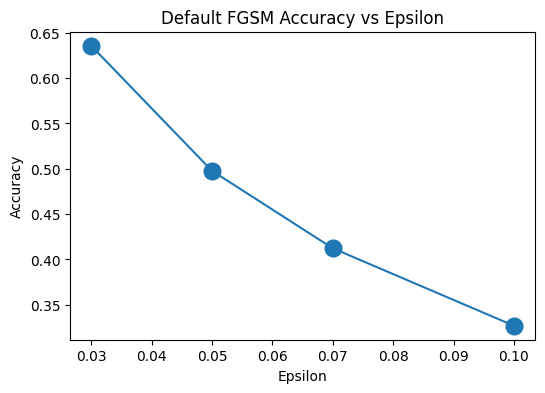

In [12]:
fig_default, ax_default = plt.subplots(figsize= (6, 4))
ax_default.plot(epsilons_default, list(fgsm_default_accuracies.values()), marker='o', markersize=12)
ax_default.set_xlabel("Epsilon")
ax_default.set_ylabel("Accuracy")
ax_default.set_title("Default FGSM Accuracy vs Epsilon")
plt.show()

## L2 FGSM

Progress: 100%|████████| 12630/12630 [02:30<00:00, 83.83it/s]
Test Accuracy : 0.7991290577988915 : 100%|█| 12630/12630 [00:


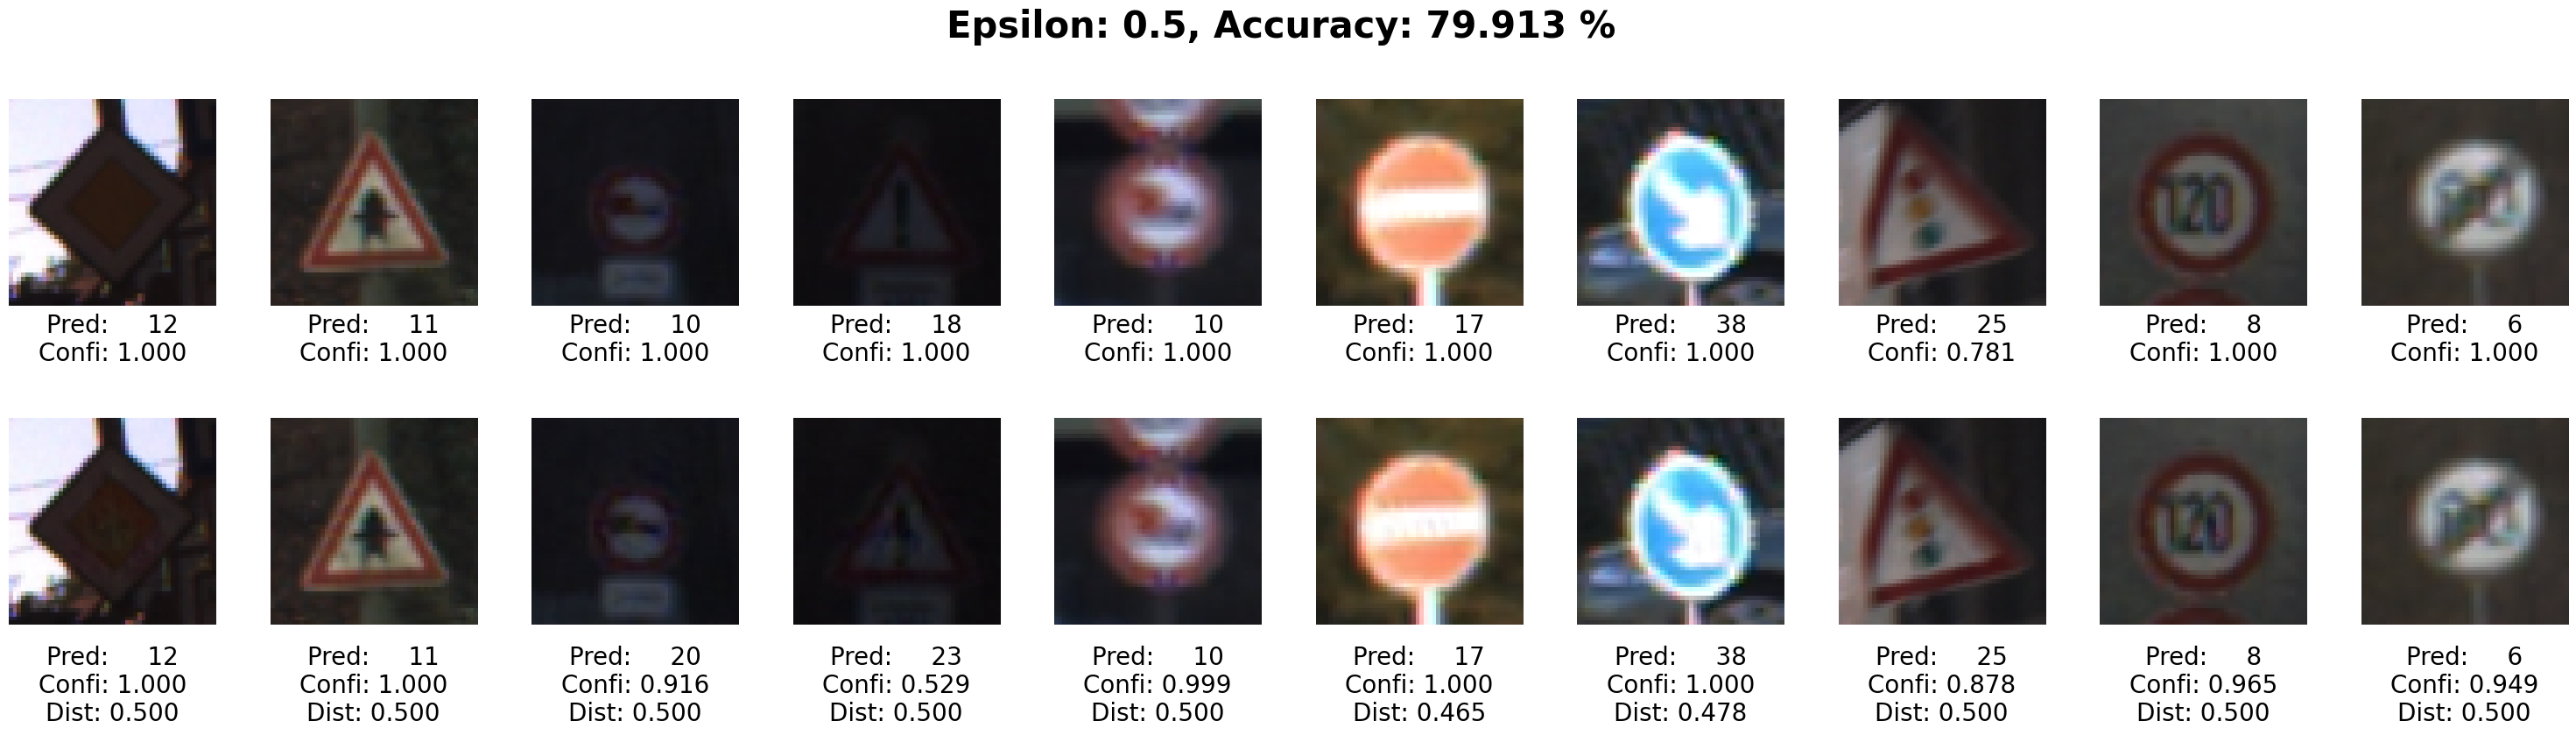

Progress: 100%|████████| 12630/12630 [02:25<00:00, 87.03it/s]
Test Accuracy : 0.6540775930324624 : 100%|█| 12630/12630 [00:


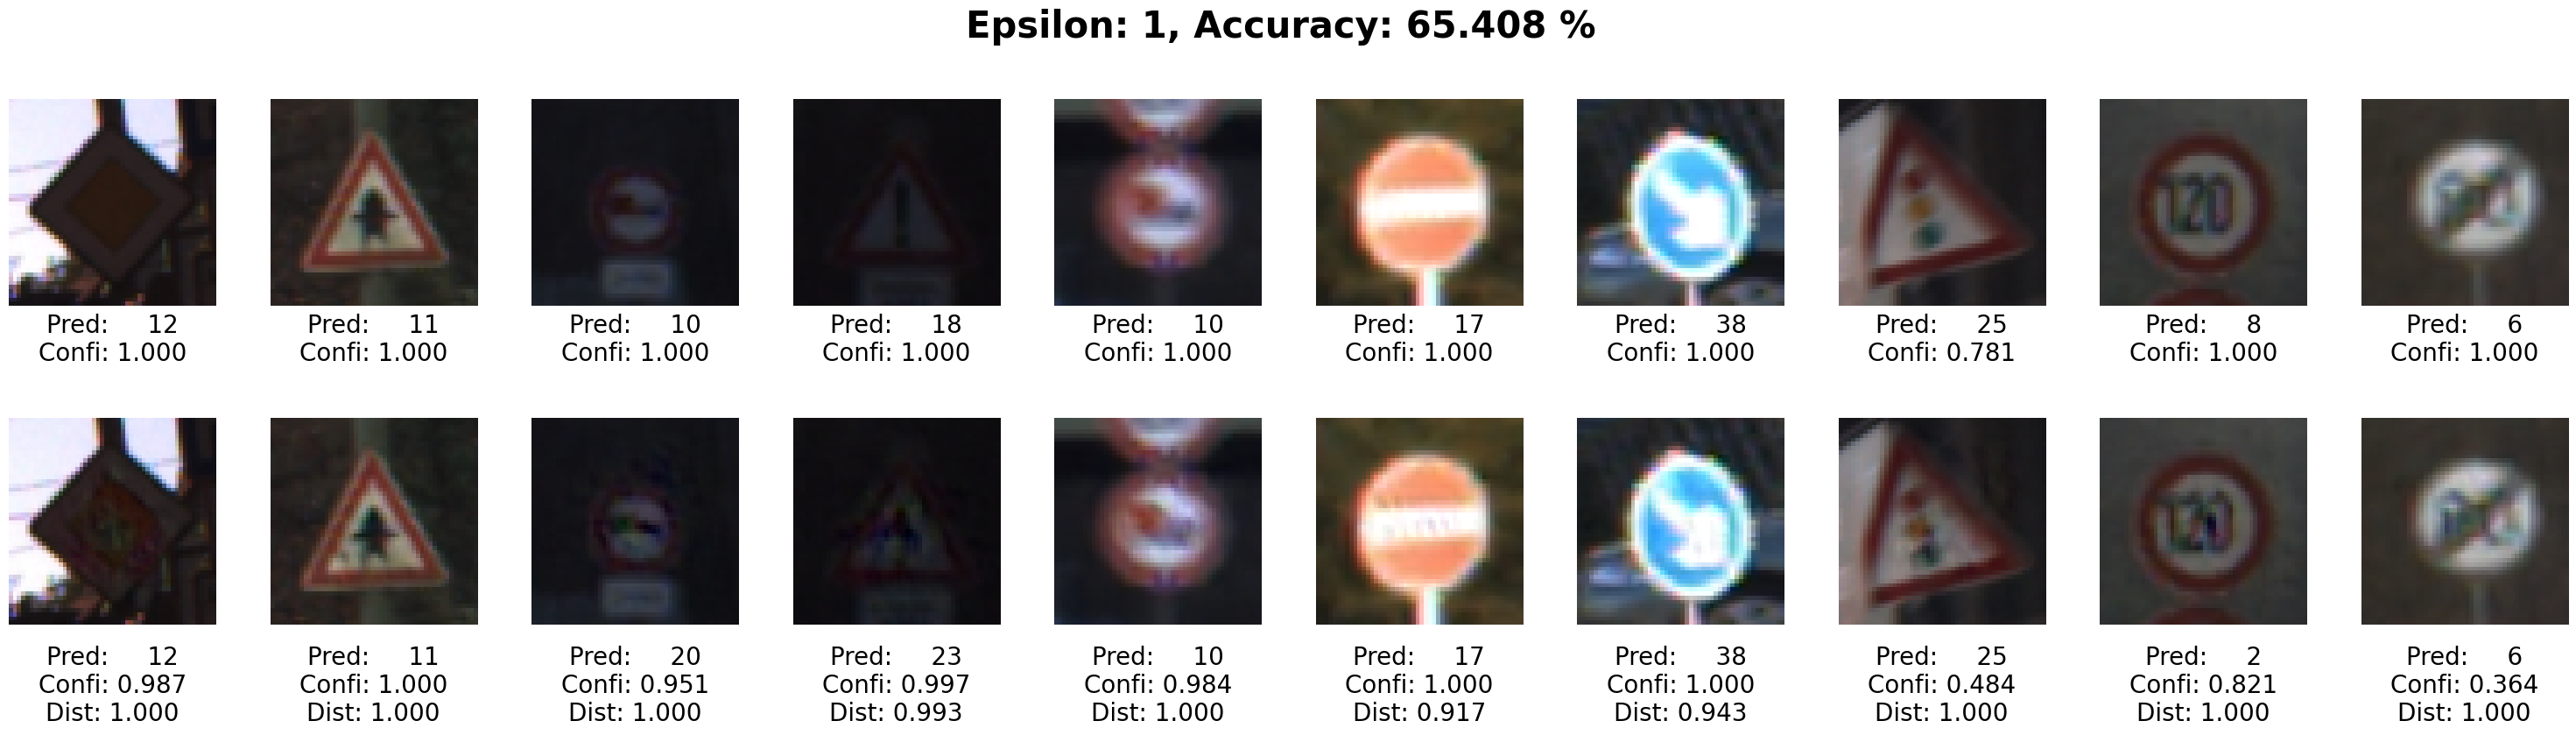

Progress: 100%|████████| 12630/12630 [02:17<00:00, 92.10it/s]
Test Accuracy : 0.4927949326999208 : 100%|█| 12630/12630 [01:


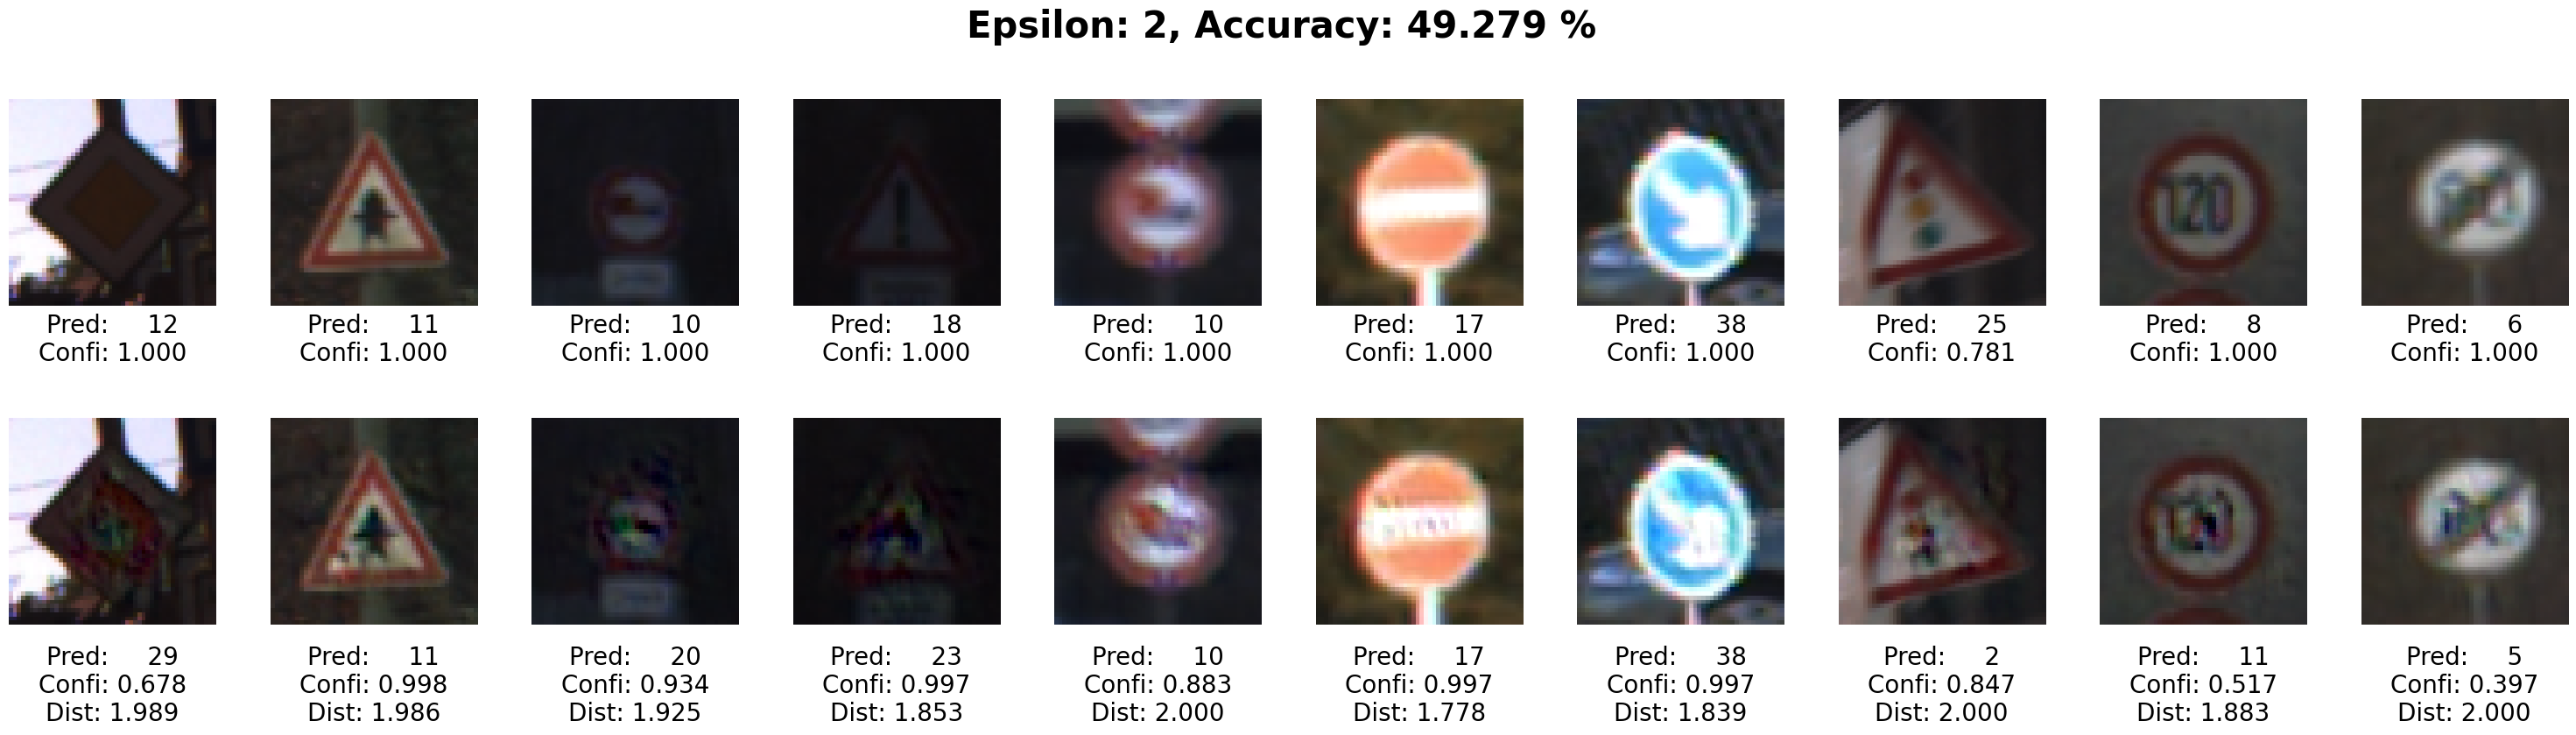

Progress: 100%|████████| 12630/12630 [02:16<00:00, 92.57it/s]
Test Accuracy : 0.2967537608867775 : 100%|█| 12630/12630 [01:


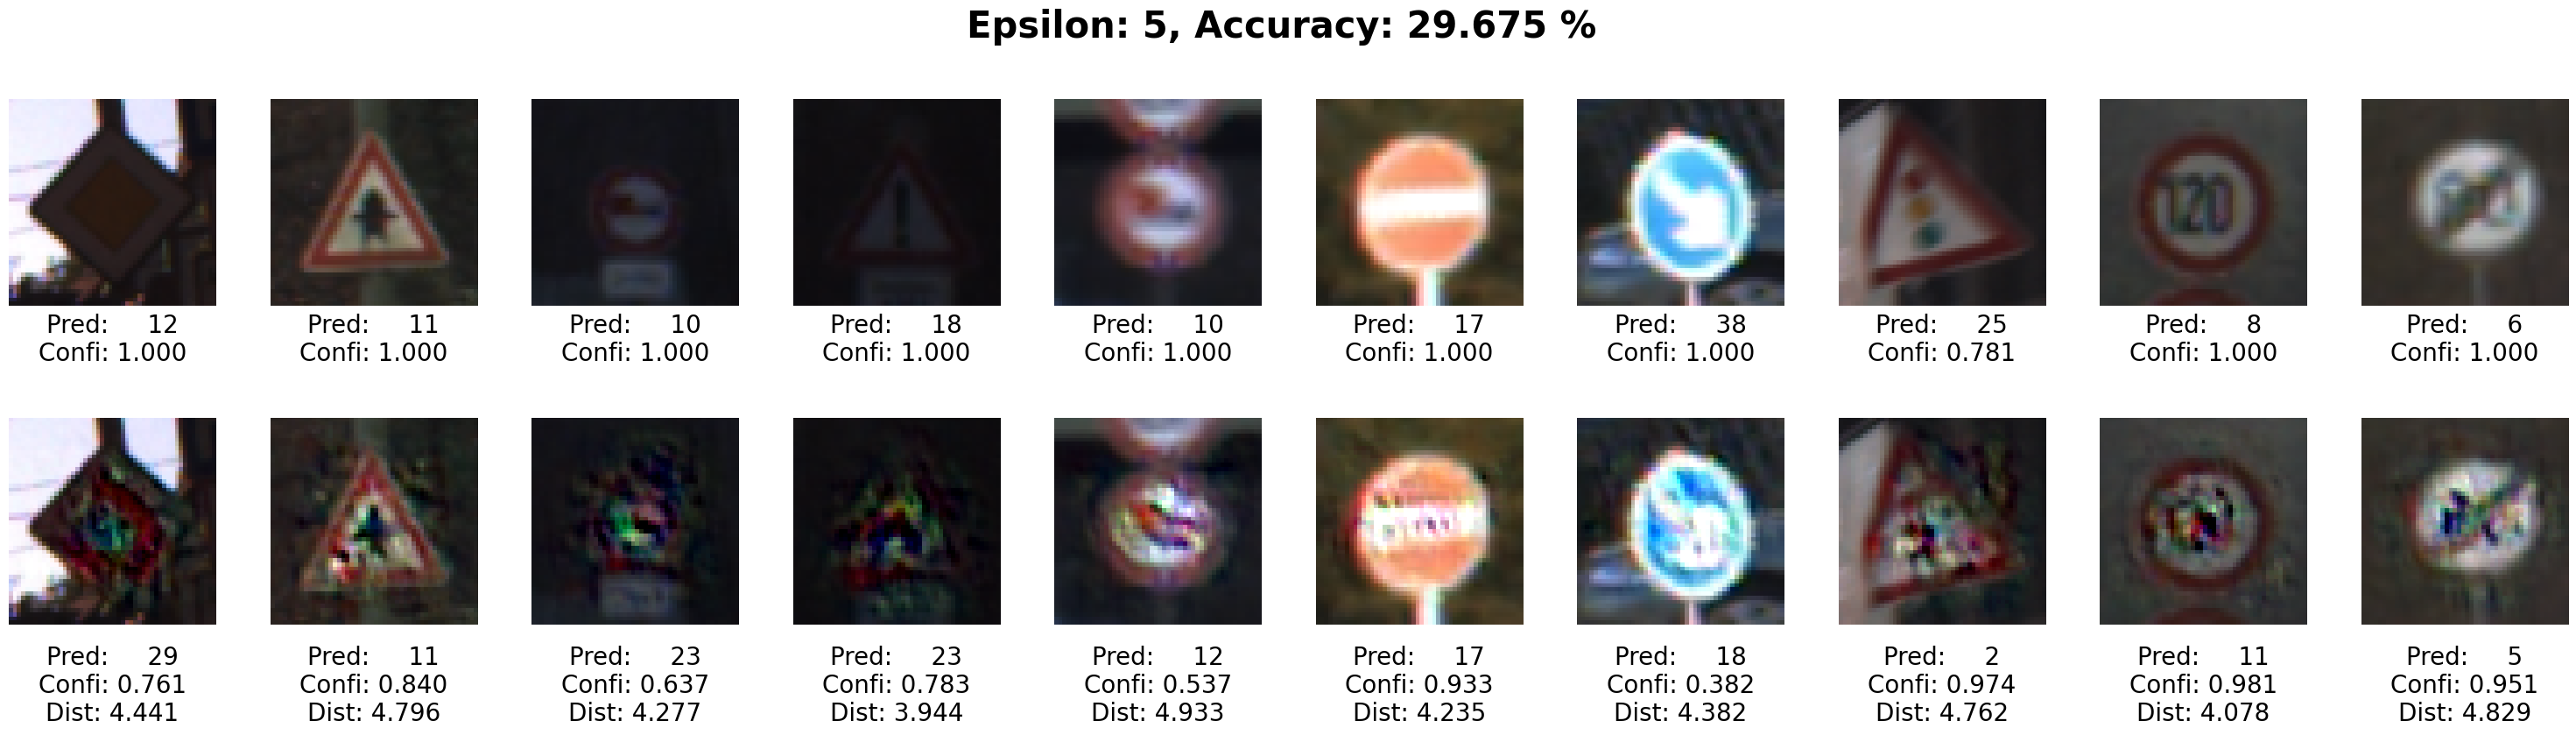

In [13]:
def generate_adversarial_dataset_fgsm_l2(model, device, test_loader, epsilon):
    adv_examples = []

    with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
        # Loop over all examples in test set
        for data, target in test_loader:
            # Send the data and label to the device
            data, target = data.to(device), target.to(device)
            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True
            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            # If the initial prediction is wrong, don't bother attacking, just move on
            # if init_pred.item() != target.item():
            #     adv_examples.append((data.squeeze().detach().cpu(), target))
            #     progress.update(1)
            #     continue
            # Calculate the loss
            loss = F.nll_loss(output, target)
            # Zero all existing gradients
            model.zero_grad()
            # Calculate gradients of model in backward pass
            loss.backward()
            # Collect ``datagrad``
            data_grad = data.grad.data
            # Call FGSM Attack
            perturbed_data = fgsm_attack_l2(data, epsilon, data_grad)
            # Re-classify the perturbed image
            output = model(perturbed_data)
            adv_ex = perturbed_data.squeeze().detach().cpu()
            adv_examples.append((adv_ex, target))
            progress.desc = f'Progress: '
            progress.update(1)
    return adv_examples

epsilons_l2 = [0.5, 1, 2, 5]
fgsm_l2_accuracies = generate_results(epsilons_l2,model,generate_adversarial_dataset_fgsm_l2,testdata,dist_fn = lambda a,b : (a-b).norm().detach().item())

## Small,multi steps FGSM

Progress: 100%|████████| 12630/12630 [30:35<00:00,  6.88it/s]
Test Accuracy : 0.671021377672209 : 100%|█| 12630/12630 [01:1


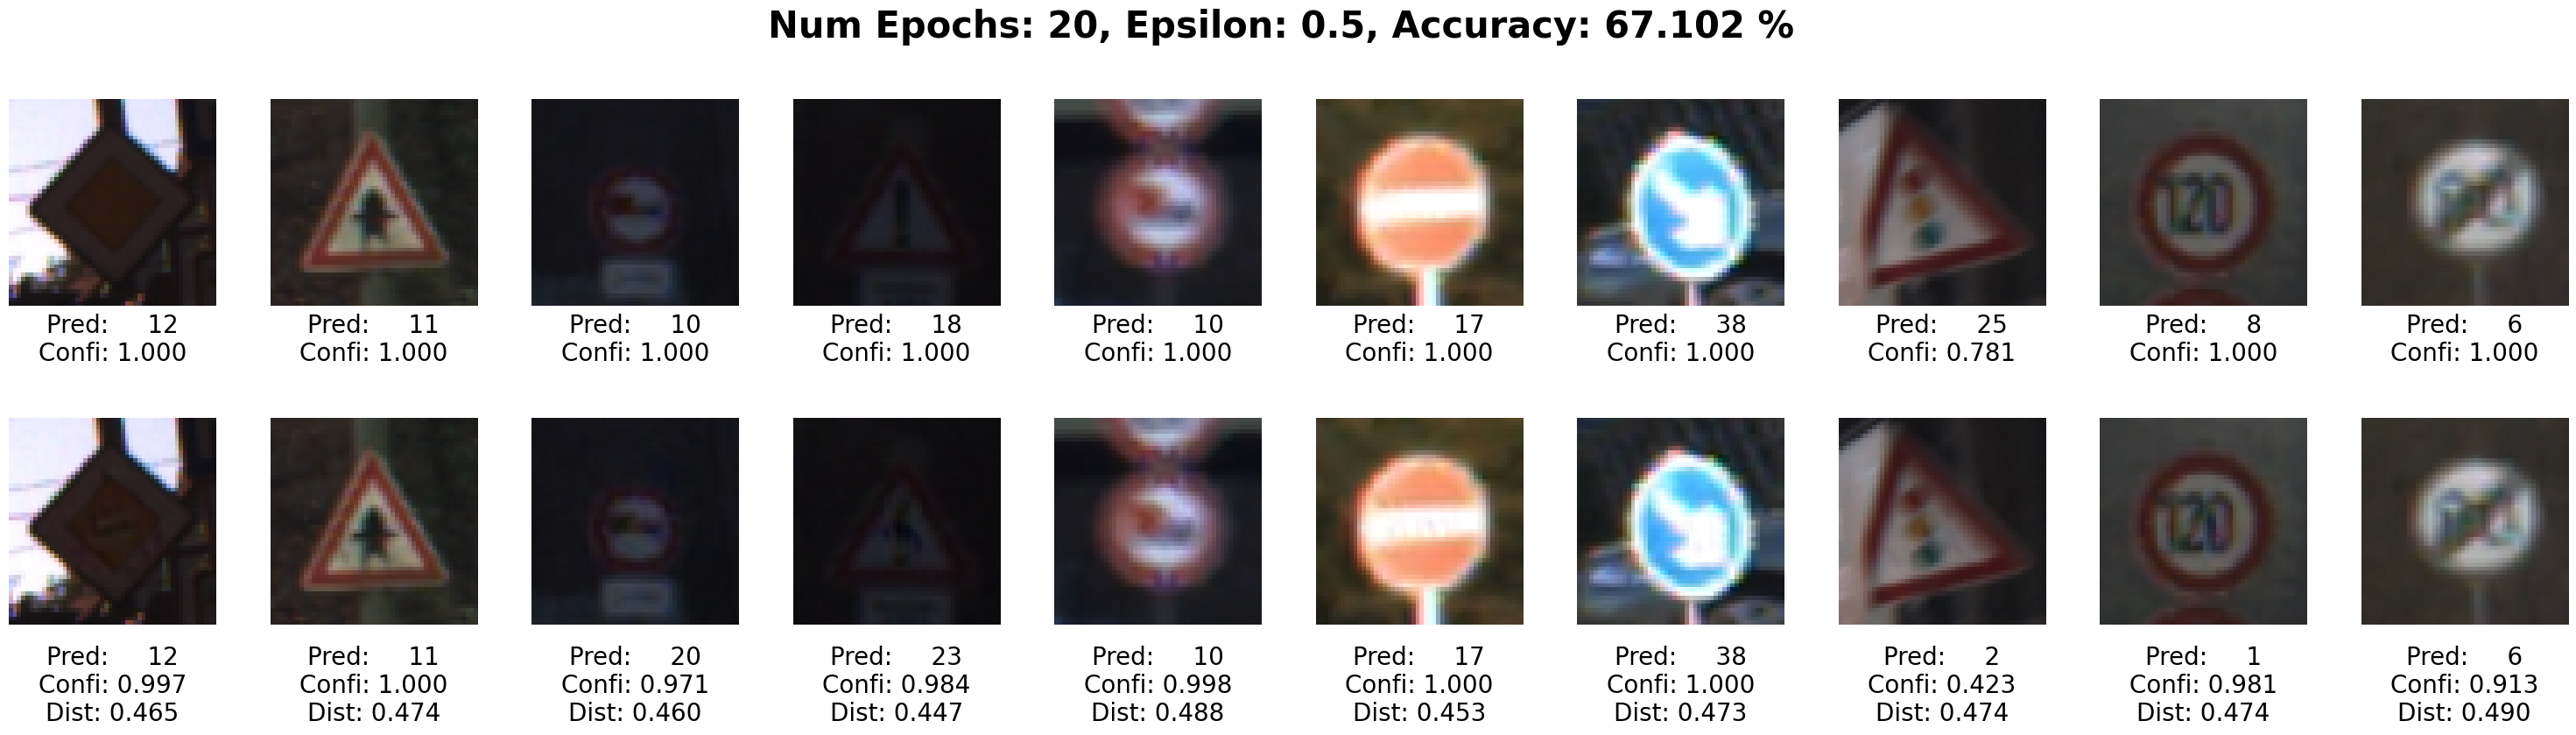

Progress: 100%|████████| 12630/12630 [30:40<00:00,  6.86it/s]
Test Accuracy : 0.41250989707046715 : 100%|█| 12630/12630 [01


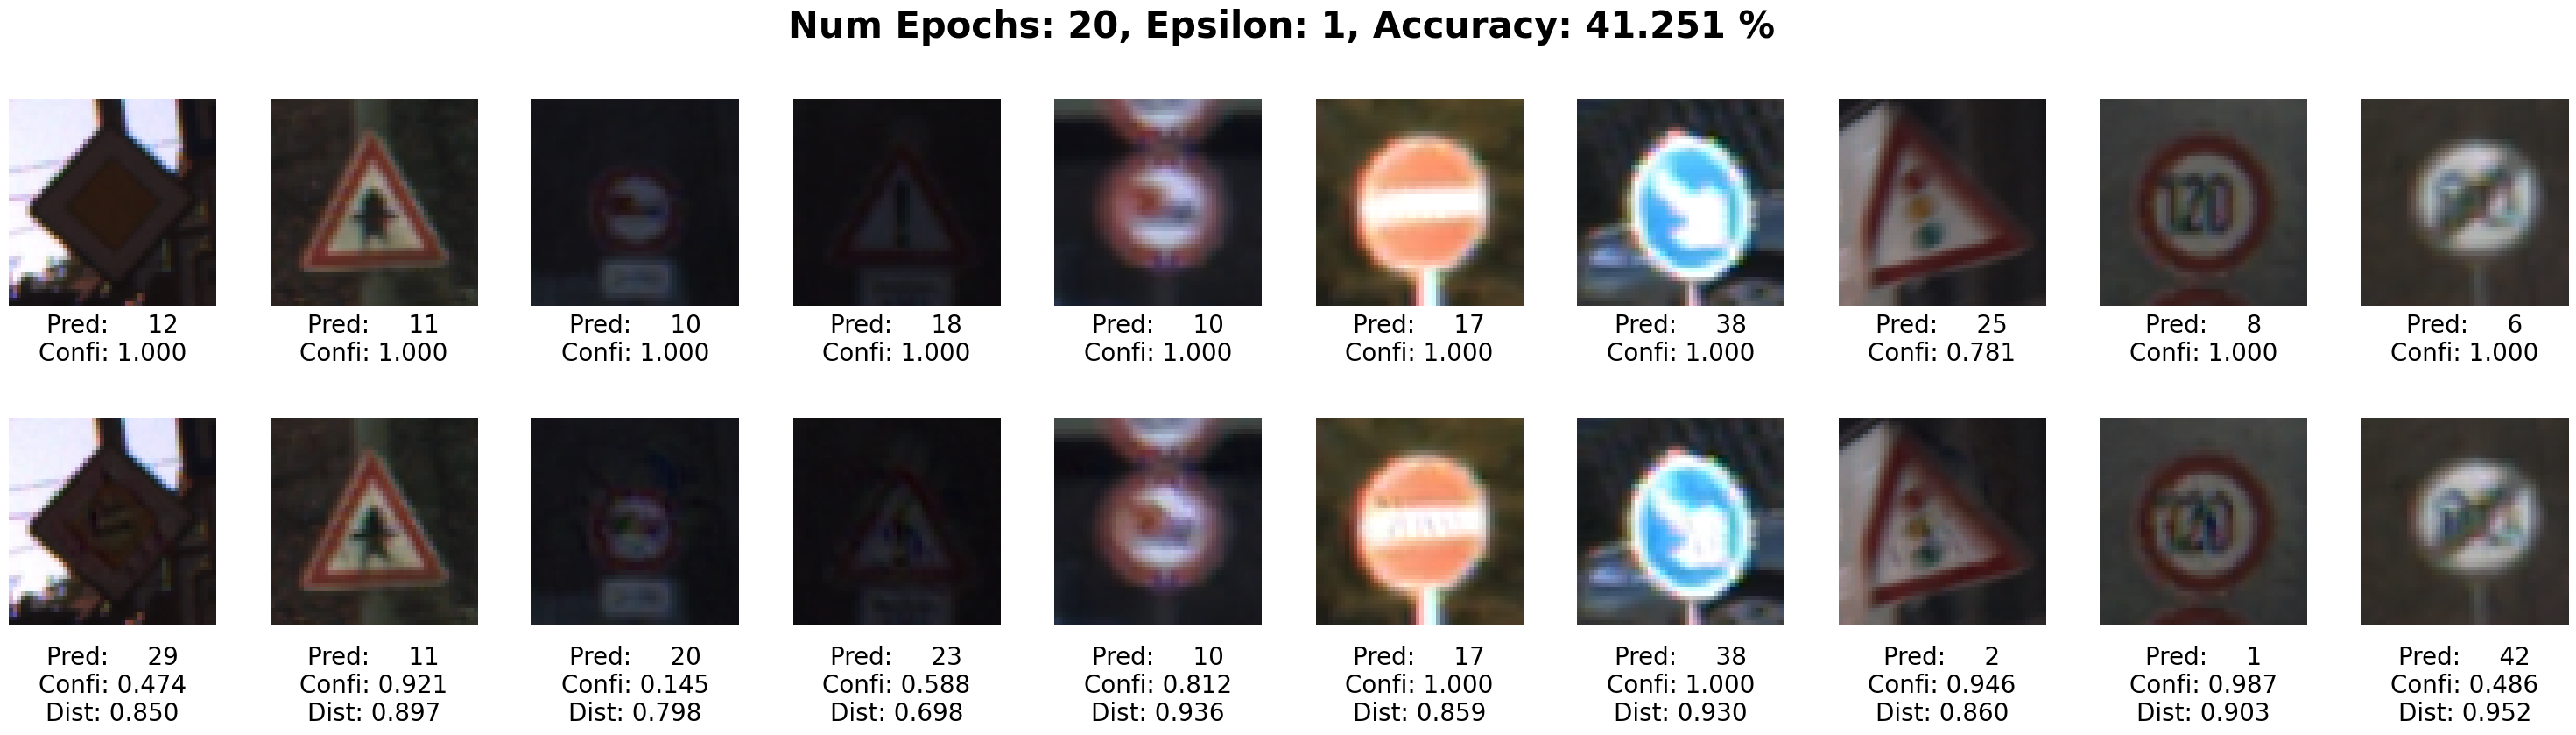

Progress: 100%|████████| 12630/12630 [34:51<00:00,  6.04it/s]
Test Accuracy : 0.16920031670625496 : 100%|█| 12630/12630 [01


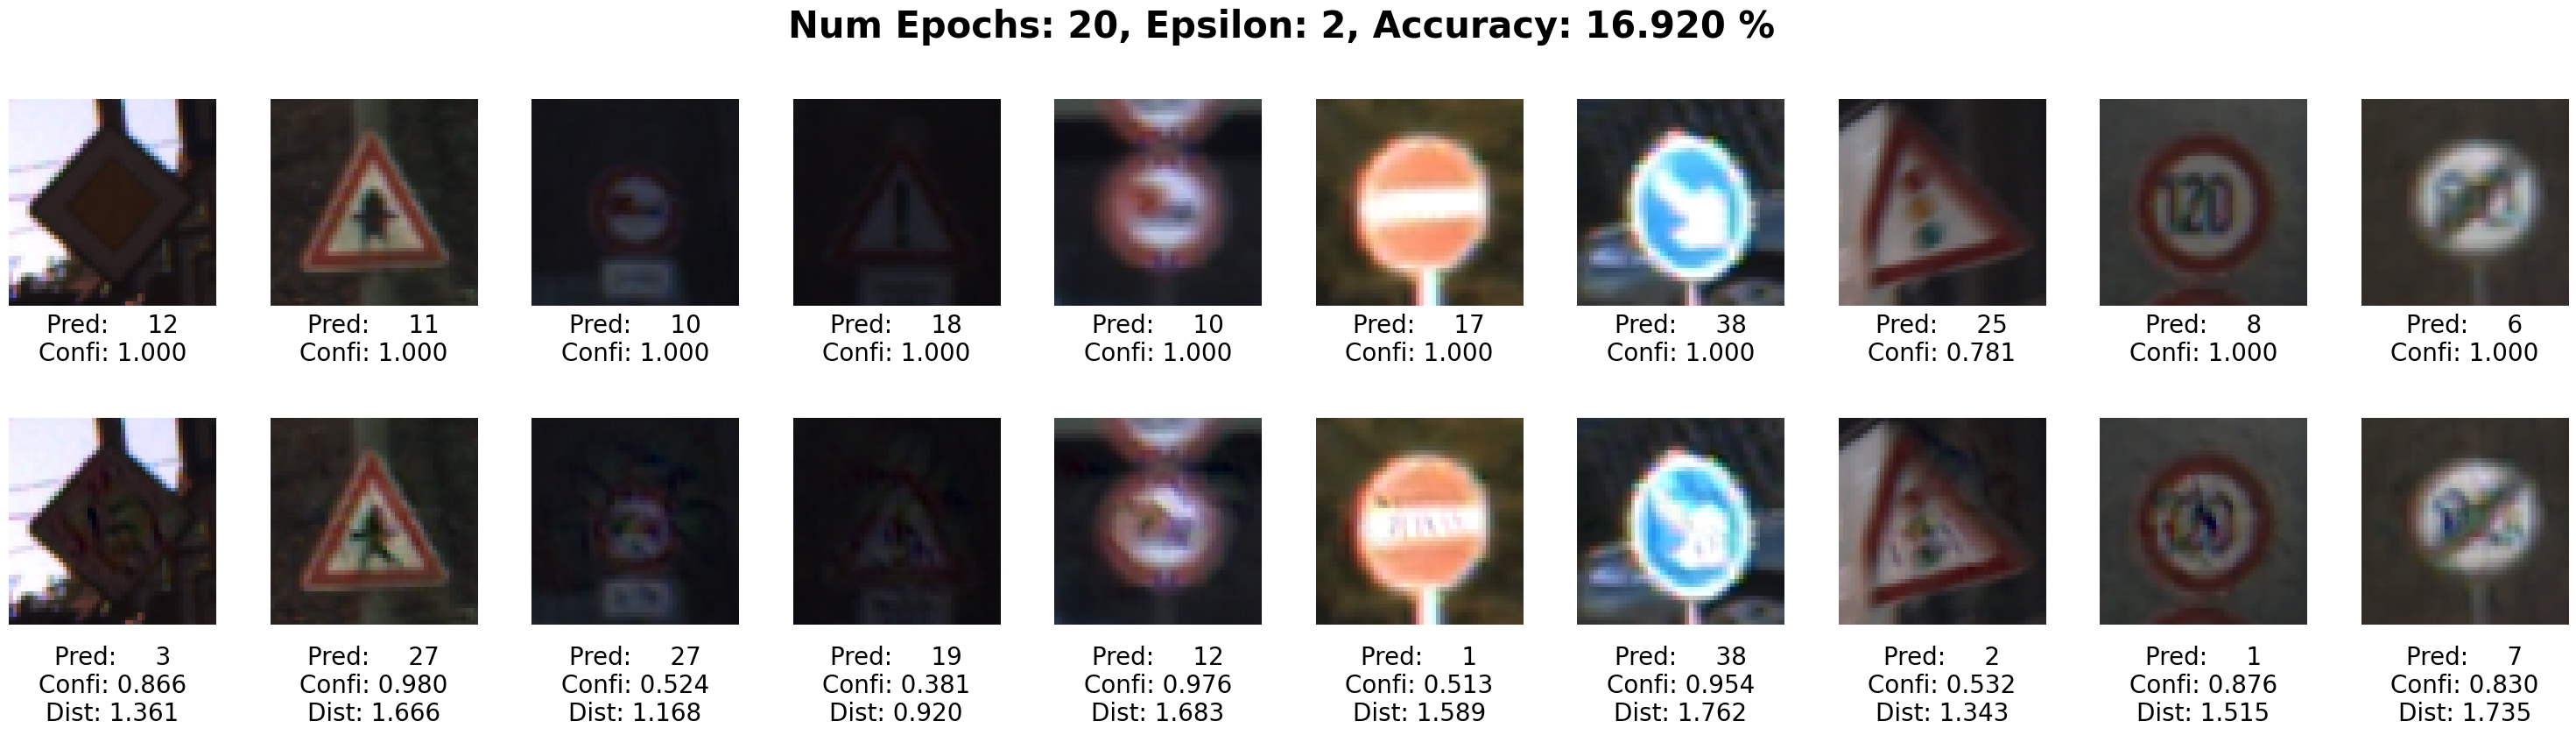

Progress: 100%|████████| 12630/12630 [32:00<00:00,  6.57it/s]
Test Accuracy : 0.015518606492478226 : 100%|█| 12630/12630 [0


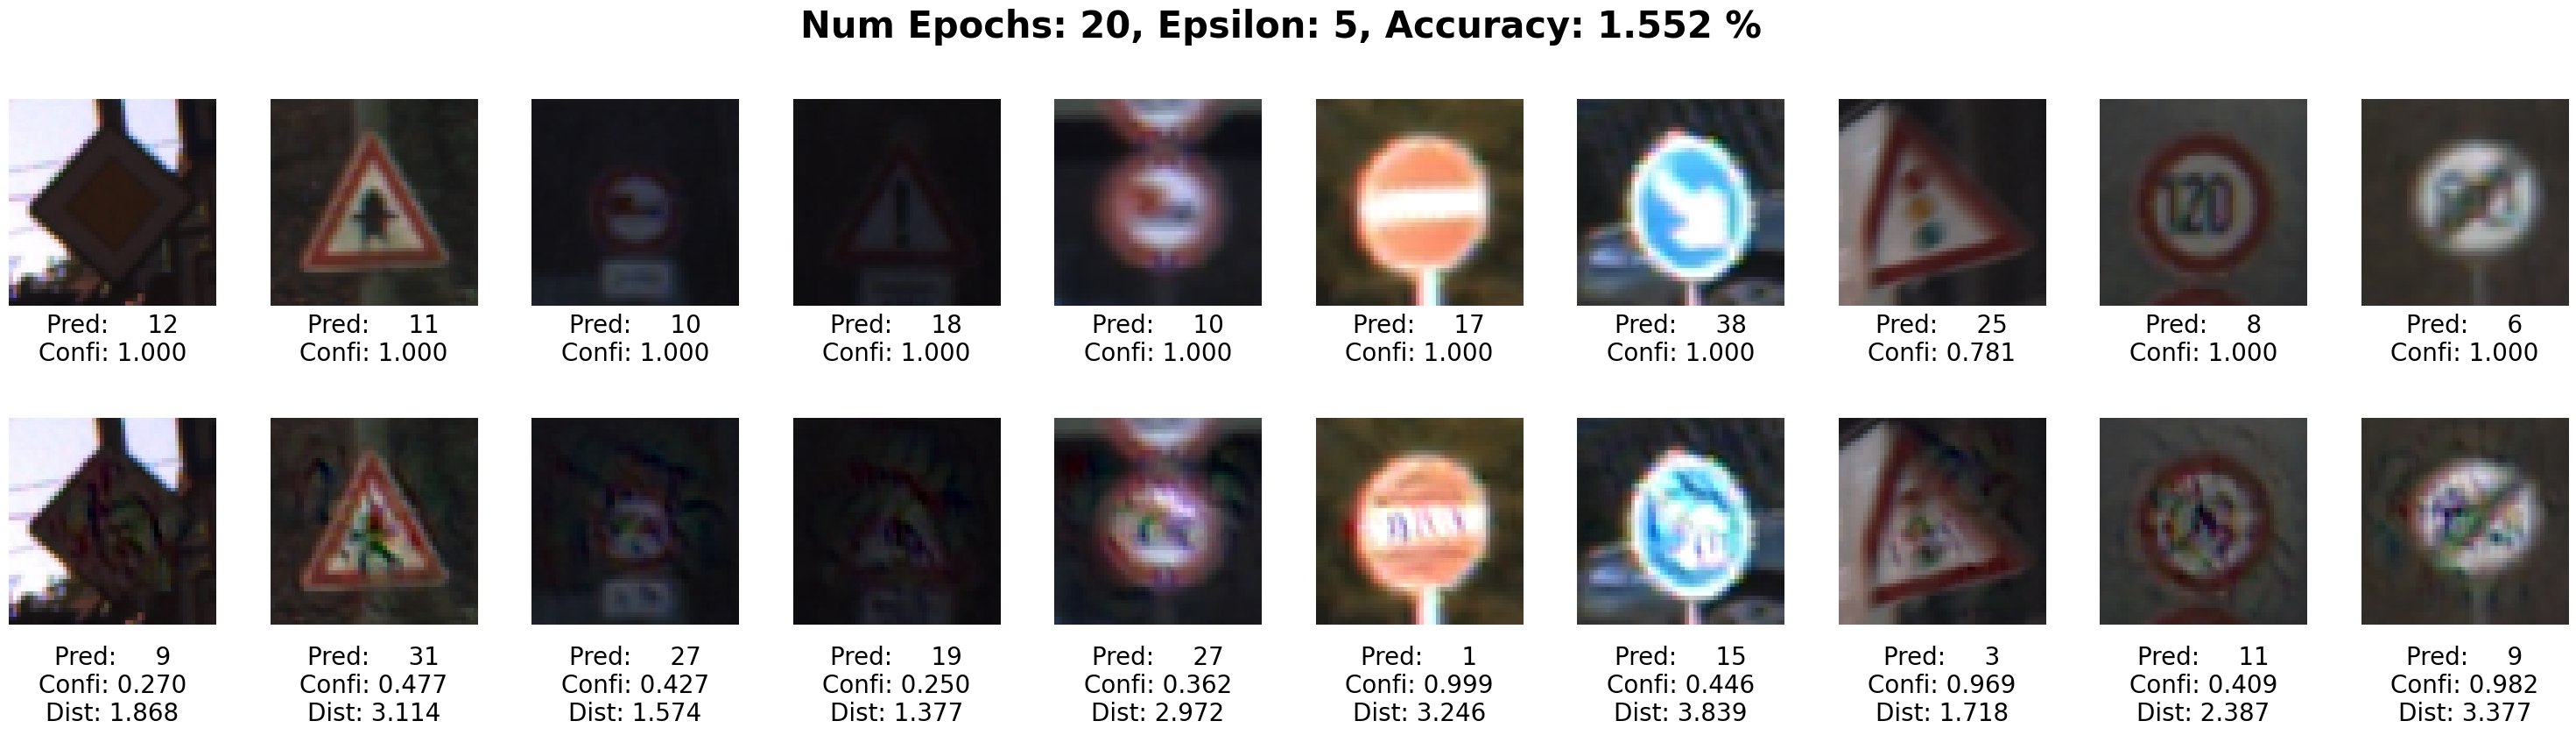

In [14]:
class CustomOptimizer(torch.optim.Optimizer): 
    # Init Method: 
    def __init__(self, params, lr=1e-3): 
        super(CustomOptimizer, self).__init__(params, defaults={'lr': lr}) 
        self.state = dict() 

    # Step Method 
    def step(self):
        for group in self.param_groups: 
            for p in group['params']: 
                p.data -= group['lr'] * p.grad.data / p.grad.data.norm()
                p.data = p.data.clamp(0,1)

def generate_adversarial_dataset_fgsm_multistep(model, device, test_loader,epsilon,num_epochs=20):
    adv_examples = []

    with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
        # Loop over all examples in test set
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data.requires_grad = True
            # epsilon = epsilon/num_epochs
            optimizer = CustomOptimizer([data],lr=epsilon/num_epochs)
            for epoch in range(num_epochs):
                output = model(data)
                optimizer.zero_grad()
                loss = -1 * F.nll_loss(output, target)
                loss.backward()
                optimizer.step()
            adv_ex = data.clamp(0,1).squeeze().detach().cpu()
            adv_examples.append((adv_ex, target))
            progress.desc = f'Progress: '
            progress.update(1)
    return adv_examples
    
fgsm_multistep_accuracies = generate_results(epsilons_l2,model,generate_adversarial_dataset_fgsm_multistep,testdata,fn_args = {'num_epochs':20},dist_fn = lambda a,b : (a-b).norm().detach().item())

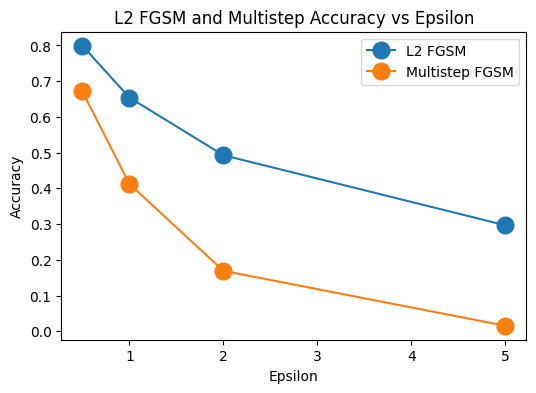

In [15]:
fig_l2, ax_l2 = plt.subplots(figsize= (6, 4))
ax_l2.plot(epsilons_l2, list(fgsm_l2_accuracies.values()), marker='o', markersize=12, label="L2 FGSM")
ax_l2.plot(epsilons_l2, list(fgsm_multistep_accuracies.values()), marker='o', markersize=12, label="Multistep FGSM")
ax_l2.set_xlabel("Epsilon")
ax_l2.set_ylabel("Accuracy")
ax_l2.set_title("L2 FGSM and Multistep Accuracy vs Epsilon")
ax_l2.legend()
plt.show()

In [16]:
epochs = [2, 5, 10,20,30]
fgsm_multistep_accuracies_epochs = {}
for e in epochs:
    fgsm_multistep_accuracies_epochs[e] = generate_results(epsilons_l2,model,generate_adversarial_dataset_fgsm_multistep,testdata,fn_args = {'num_epochs':e},dist_fn = lambda a,b : (a-b).norm().detach().item(),show_results = False)
outfile = open('./pkl/accuracy_data.pkl','wb')
pickle.dump(fgsm_multistep_accuracies_epochs,outfile)
outfile.close()

Progress: 100%|████████| 12630/12630 [03:30<00:00, 60.03it/s]
Test Accuracy : 0.7335708630245448 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [03:26<00:00, 61.29it/s]
Test Accuracy : 0.5167854315122724 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [03:30<00:00, 59.99it/s]
Test Accuracy : 0.2873317498020586 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [03:33<00:00, 59.21it/s]
Test Accuracy : 0.0821852731591449 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [08:02<00:00, 26.17it/s]
Test Accuracy : 0.693507521773555 : 100%|█| 12630/12630 [01:0
Progress: 100%|████████| 12630/12630 [08:01<00:00, 26.22it/s]
Test Accuracy : 0.44299287410926363 : 100%|█| 12630/12630 [01
Progress: 100%|████████| 12630/12630 [08:02<00:00, 26.19it/s]
Test Accuracy : 0.2025336500395883 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [07:49<00:00, 26.88it/s]
Test Accuracy : 0.02842438638163104 : 100%|█| 12630/12630 [01
Progress

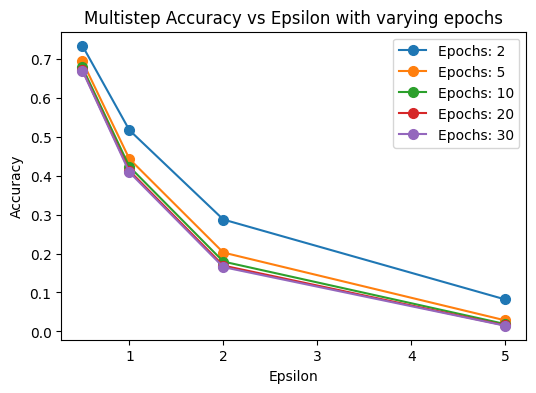

In [17]:
fig_l2_epochs, ax_l2_epochs = plt.subplots(figsize= (6, 4))
for e in epochs:
    ax_l2_epochs.plot(epsilons_l2, list(fgsm_multistep_accuracies_epochs[e].values()), marker='o', markersize=7, label=f"Epochs: {e}")
ax_l2_epochs.set_xlabel("Epsilon")
ax_l2_epochs.set_ylabel("Accuracy")
ax_l2_epochs.set_title("Multistep Accuracy vs Epsilon with varying epochs")
ax_l2_epochs.legend()
plt.show()

## L2 FGSM target

Progress: 100%|████████| 12630/12630 [02:07<00:00, 98.75it/s]
Test Accuracy : 0.20095011876484561 : 100%|█| 12630/12630 [01


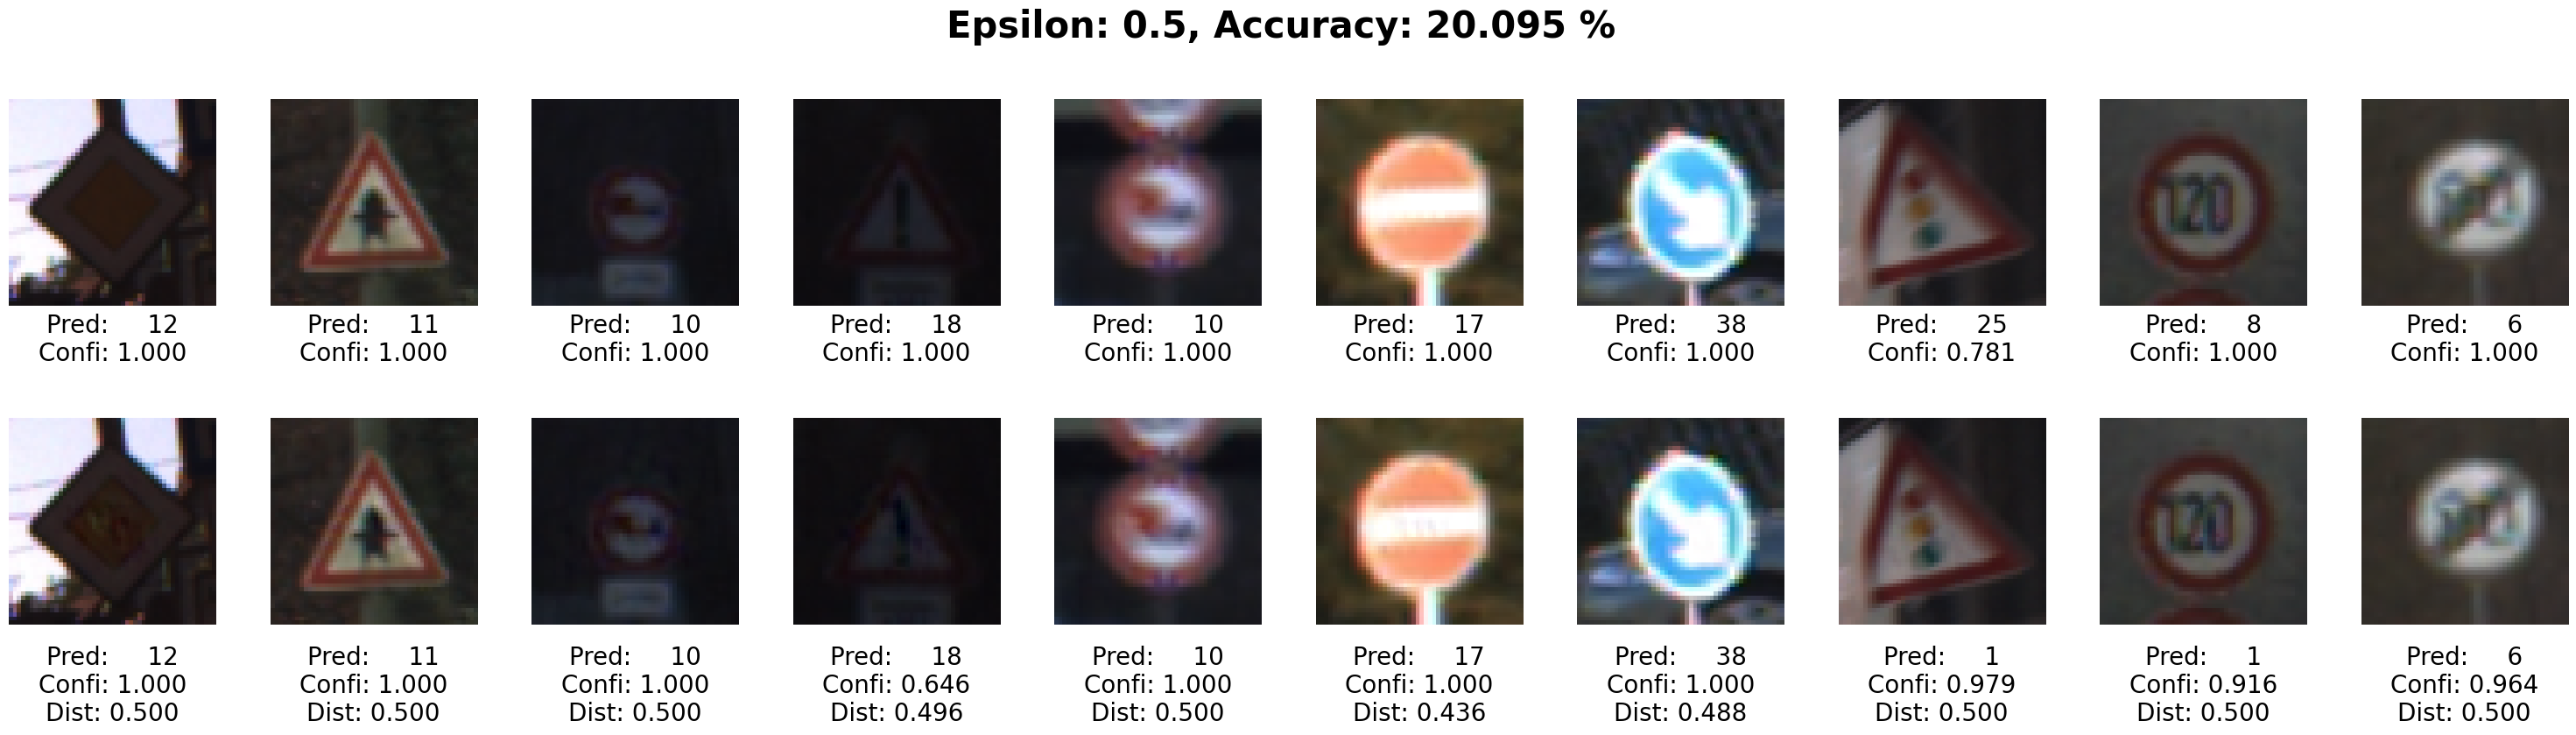

Progress: 100%|████████| 12630/12630 [02:07<00:00, 98.75it/s]
Test Accuracy : 0.33198733174980205 : 100%|█| 12630/12630 [01


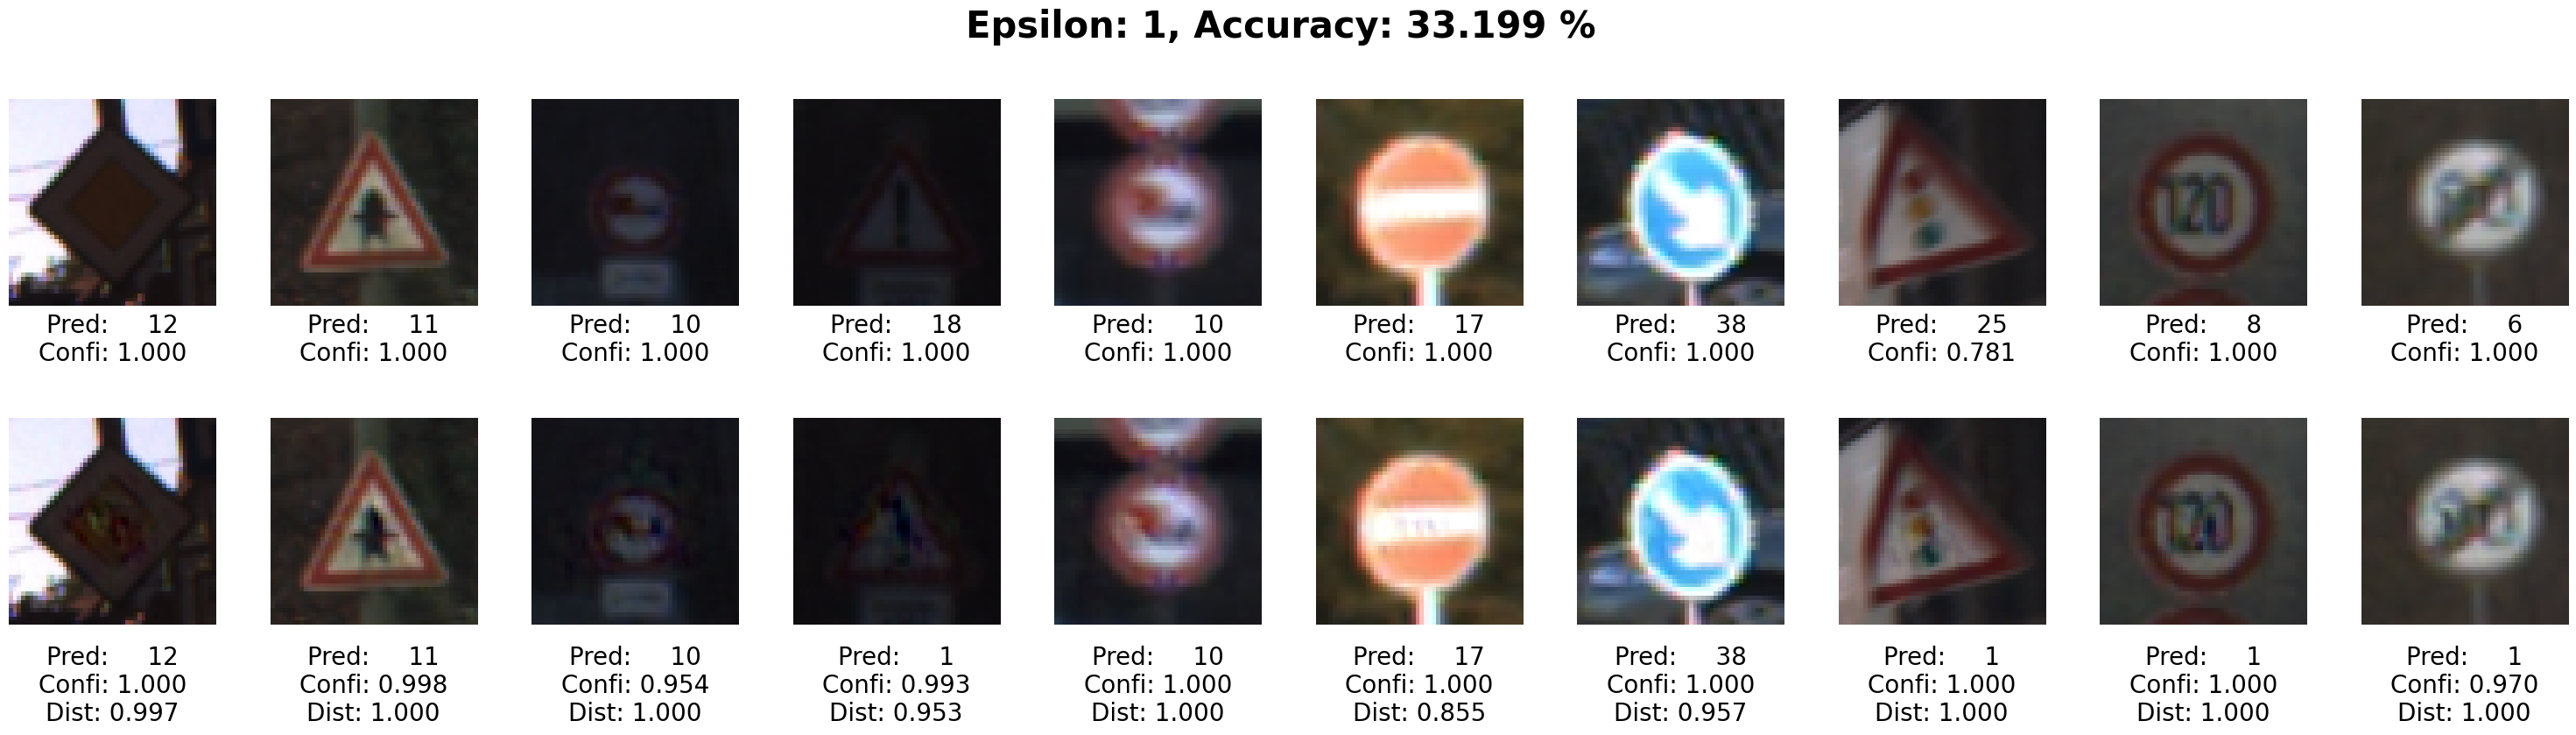

Progress: 100%|████████| 12630/12630 [02:10<00:00, 96.81it/s]
Test Accuracy : 0.4634204275534442 : 100%|█| 12630/12630 [01:


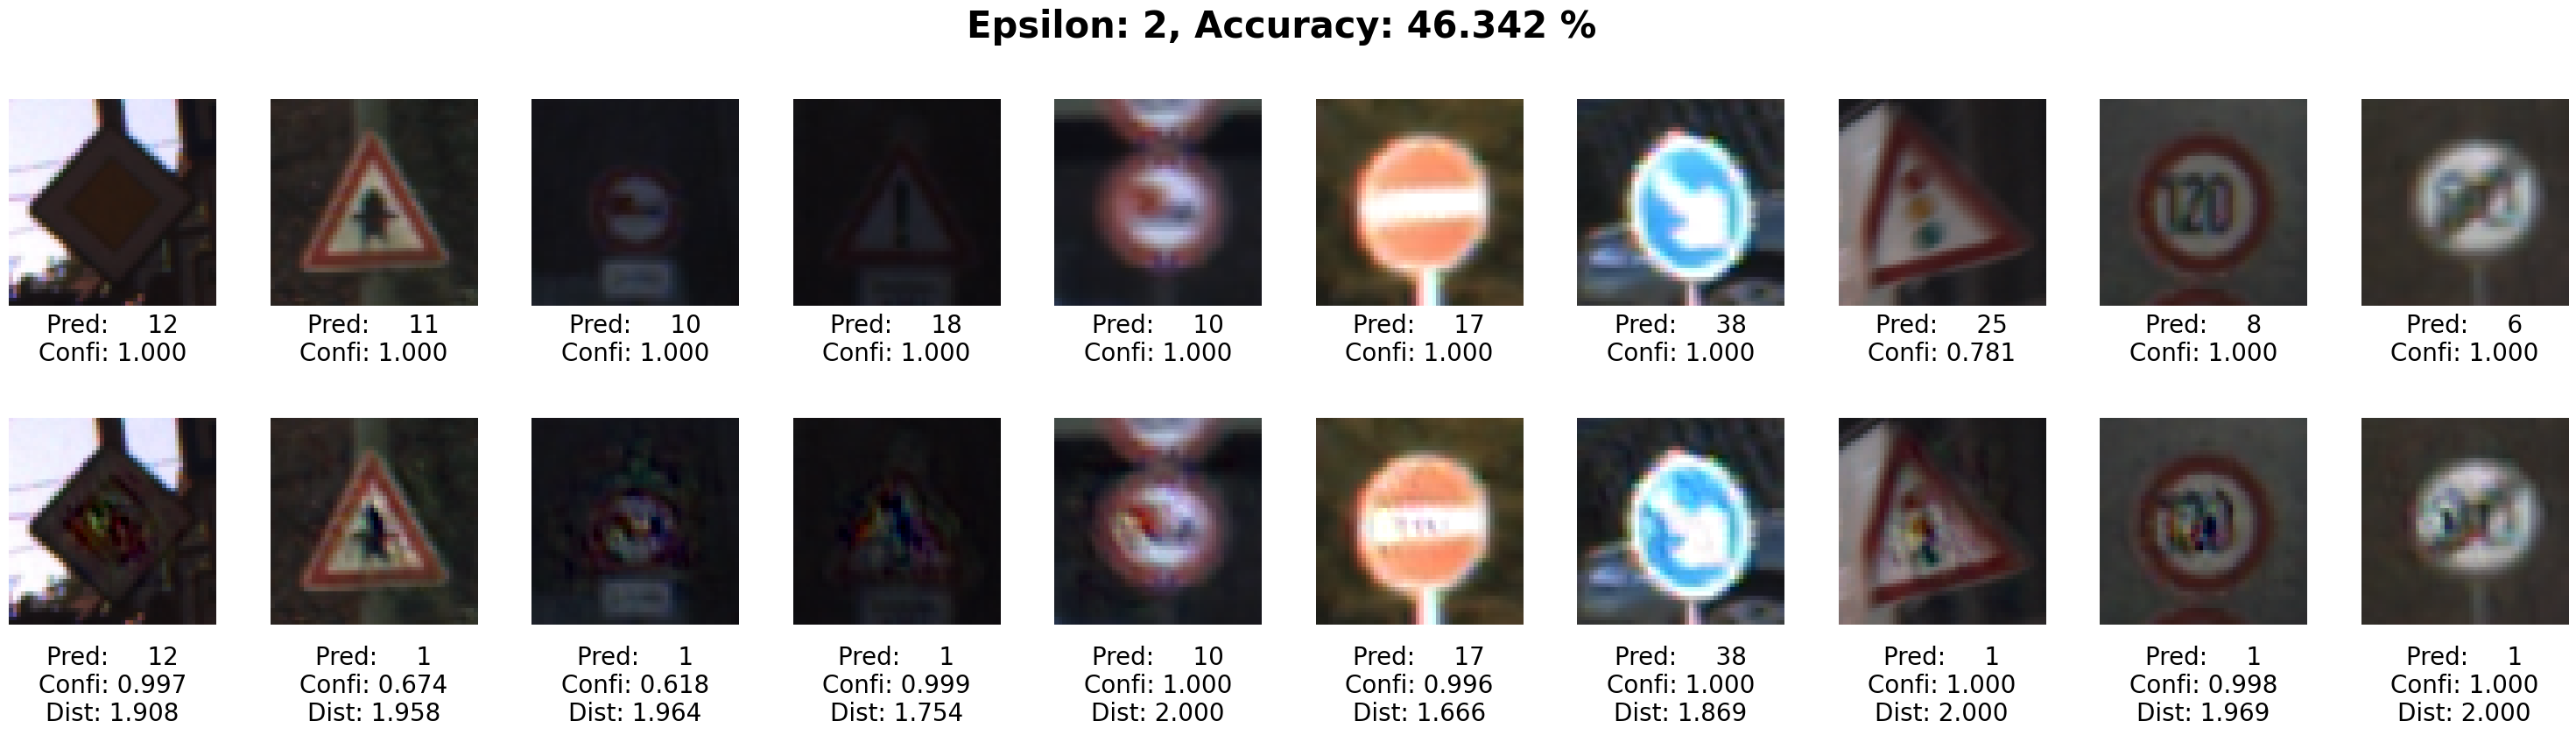

Progress: 100%|███████| 12630/12630 [02:05<00:00, 100.61it/s]
Test Accuracy : 0.5866191607284243 : 100%|█| 12630/12630 [01:


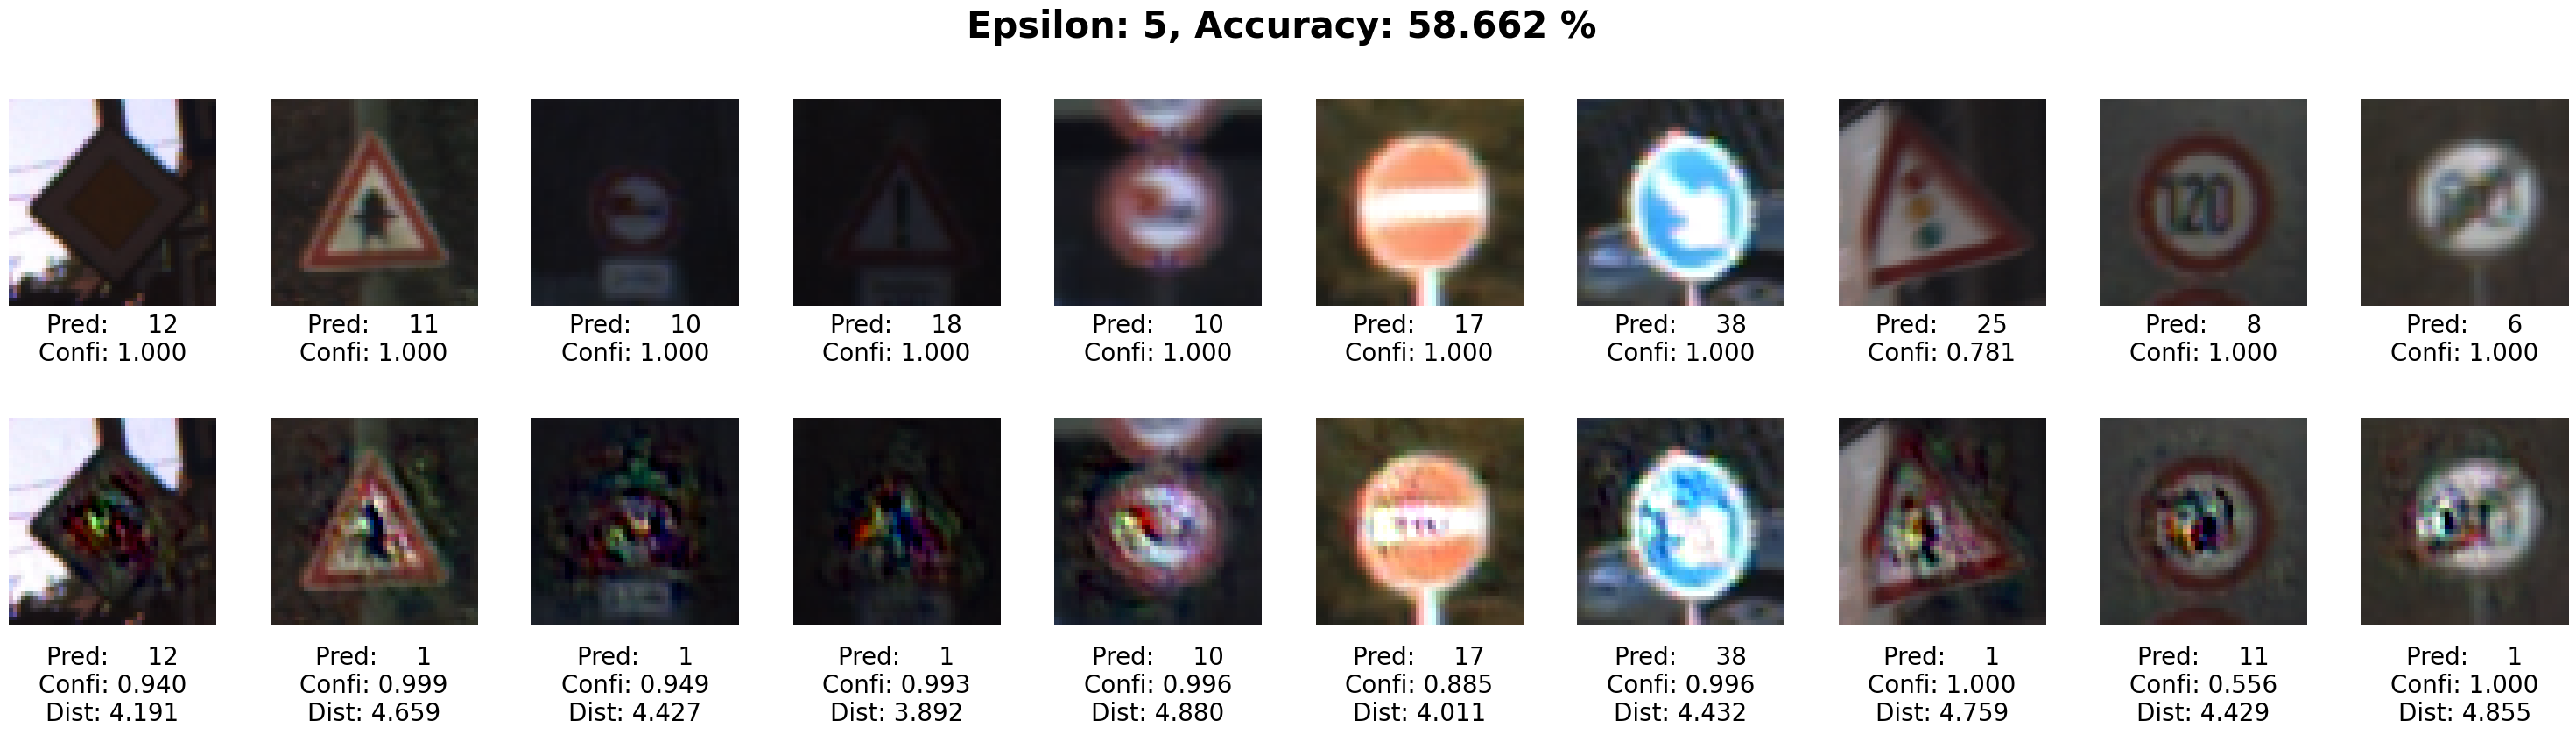

In [18]:
def generate_adversarial_dataset_fgsm_l2_targeted(model, device, test_loader, epsilon,target= torch.tensor([1])):
    adv_examples = []

    with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
        target = target.to(device)
        for data,_ in test_loader:
            data = data.to(device)
            data.requires_grad = True
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            # print(init_pred.item(),target.item())
            if(init_pred.item() != target.item()):
                loss = -1*F.nll_loss(output, target)
                model.zero_grad()
                loss.backward()
                data_grad = data.grad.data
                perturbed_data = fgsm_attack_l2(data, epsilon, data_grad)
                adv_ex = perturbed_data.squeeze().detach().cpu()
            else:
                # print("Done tight")
                adv_ex = data.squeeze().detach().cpu()
            adv_examples.append((adv_ex, target))
            progress.desc = f'Progress: '
            progress.update(1)
    return adv_examples
    
fgsm_l2_target_successrate = generate_results(epsilons_l2,model,generate_adversarial_dataset_fgsm_l2_targeted,testdata,dist_fn = lambda a,b : (a-b).norm().detach().item())

## Small,multi steps FGSM with target

Progress: 100%|████████| 12630/12630 [29:36<00:00,  7.11it/s]
Test Accuracy : 0.32256532066508314 : 100%|█| 12630/12630 [01


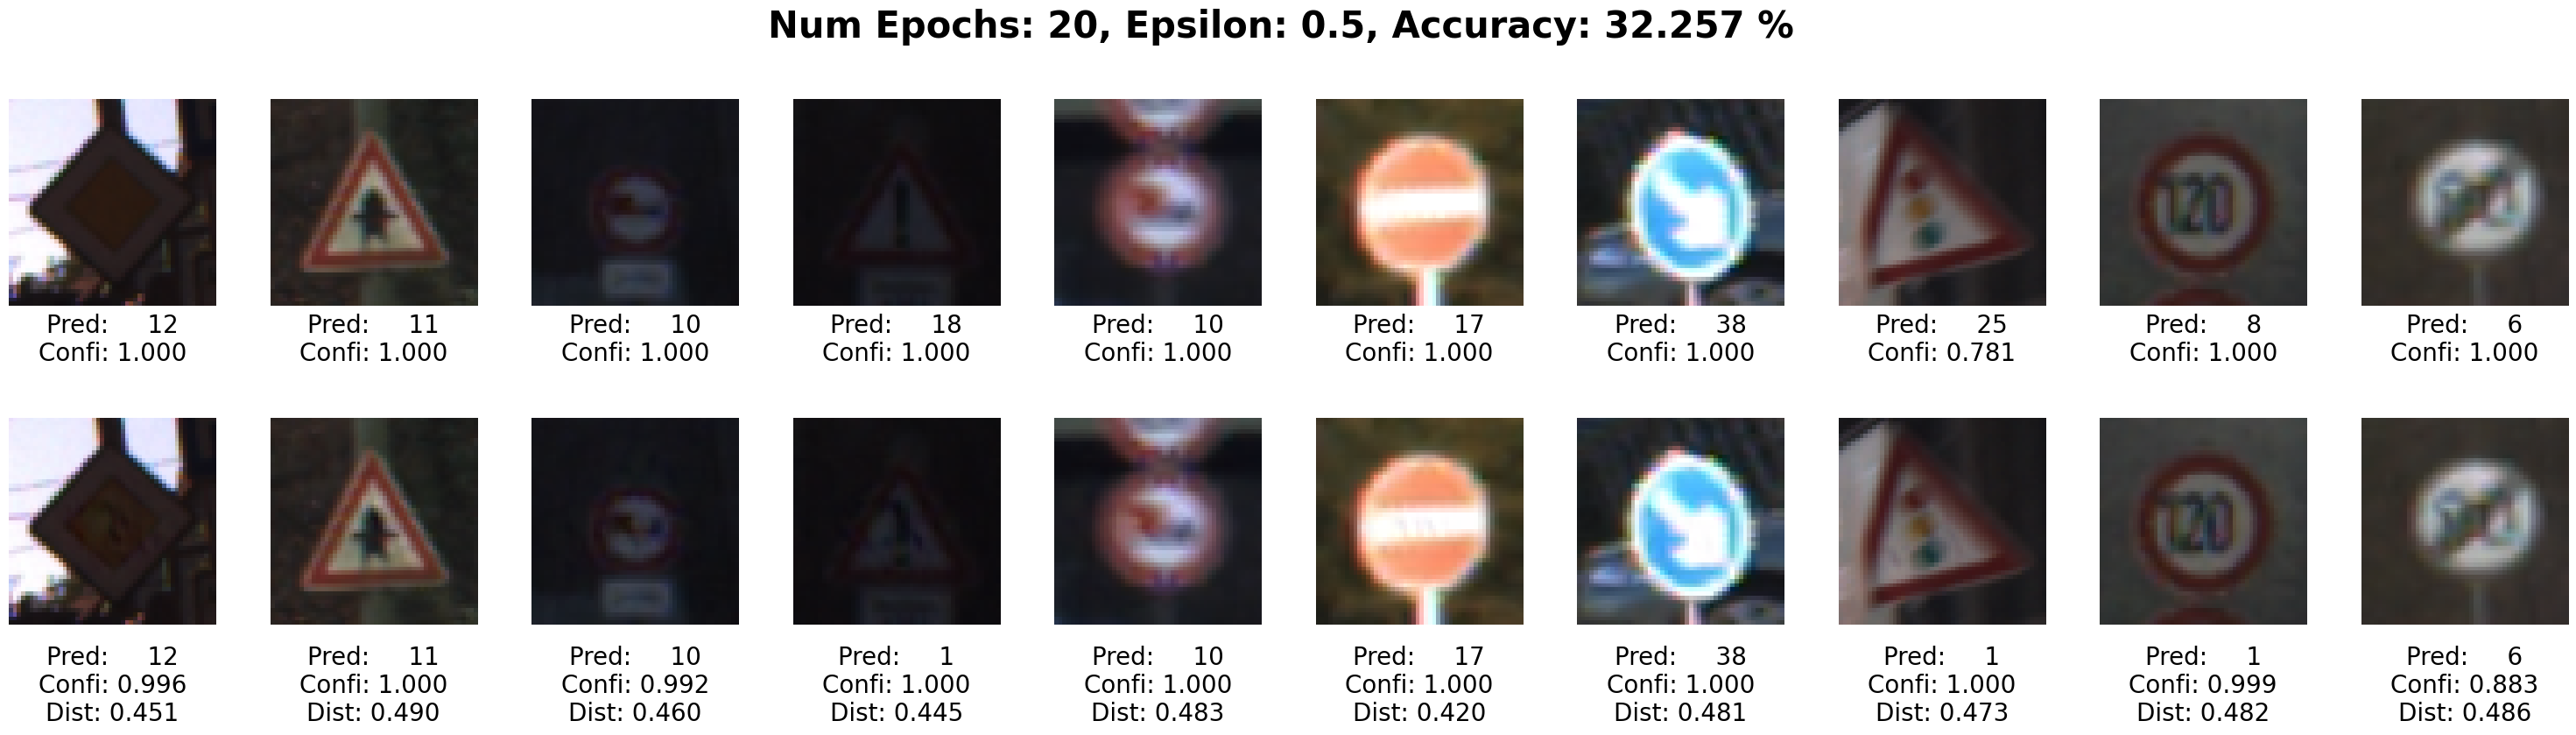

Progress: 100%|████████| 12630/12630 [30:32<00:00,  6.89it/s]
Test Accuracy : 0.5653206650831354 : 100%|█| 12630/12630 [00:


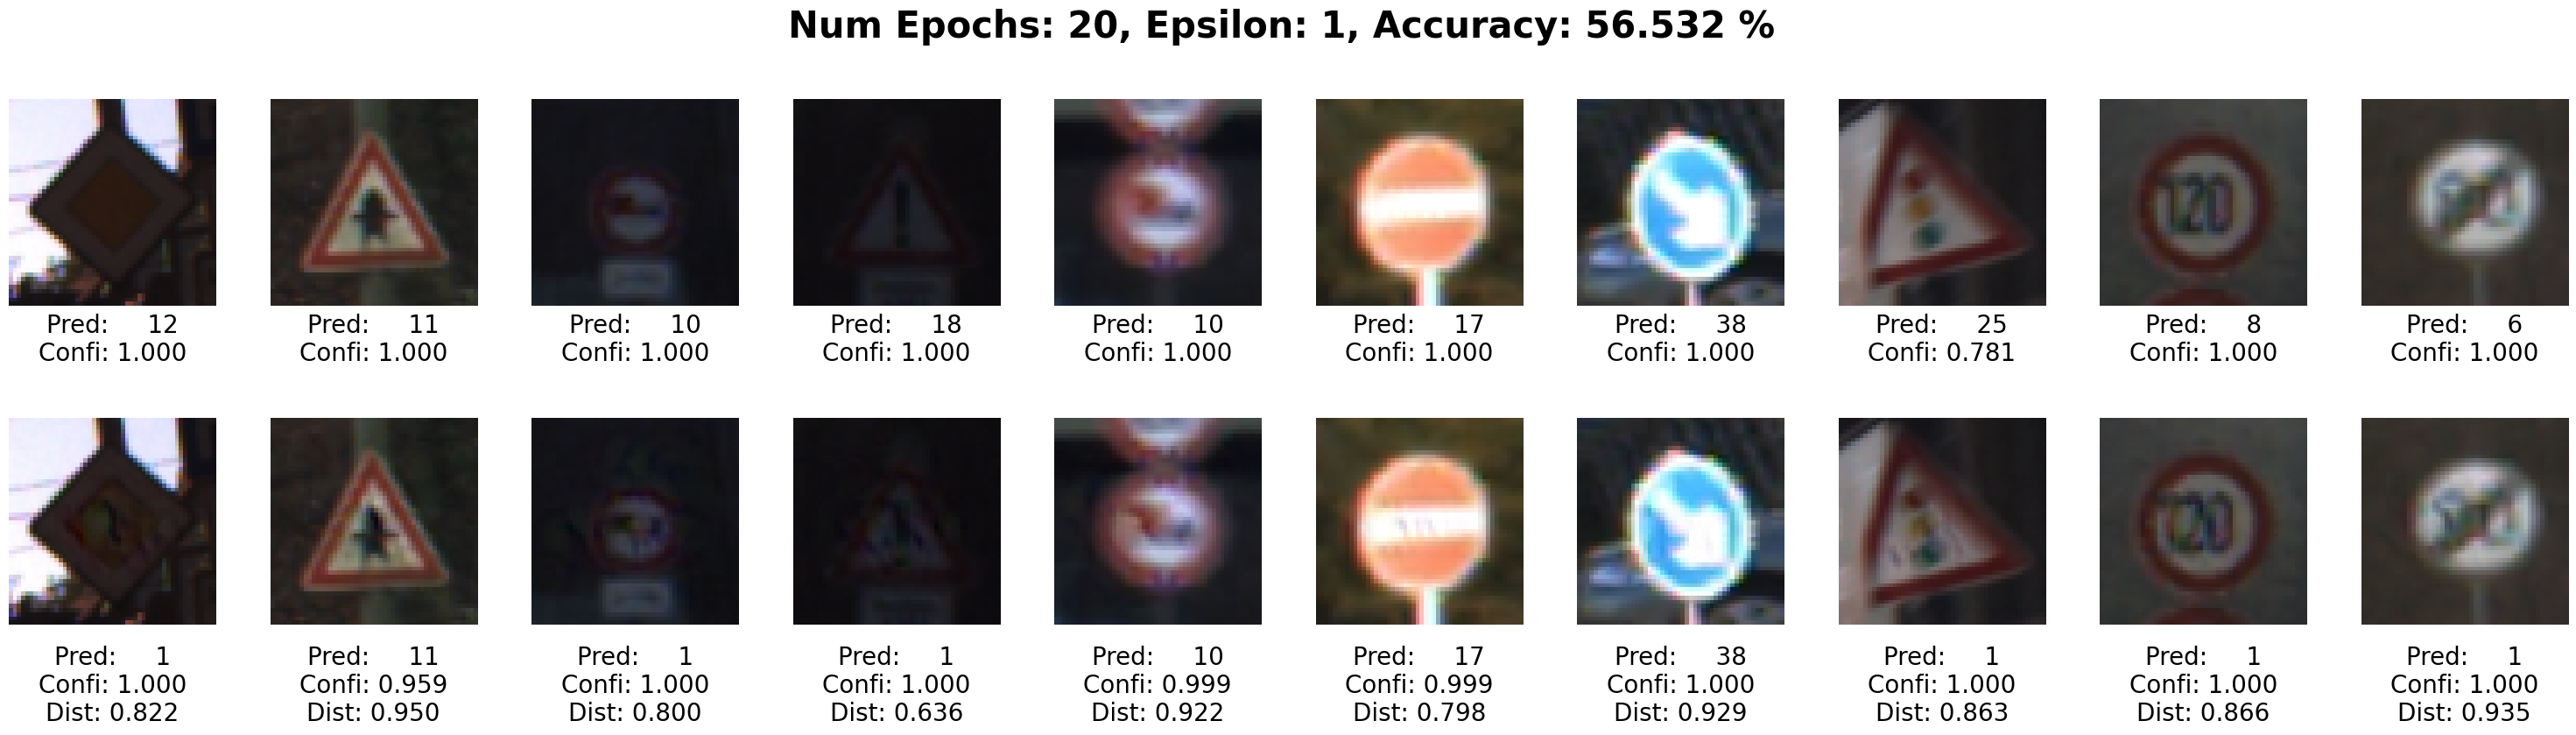

Progress: 100%|████████| 12630/12630 [29:44<00:00,  7.08it/s]
Test Accuracy : 0.8156769596199525 : 100%|█| 12630/12630 [01:


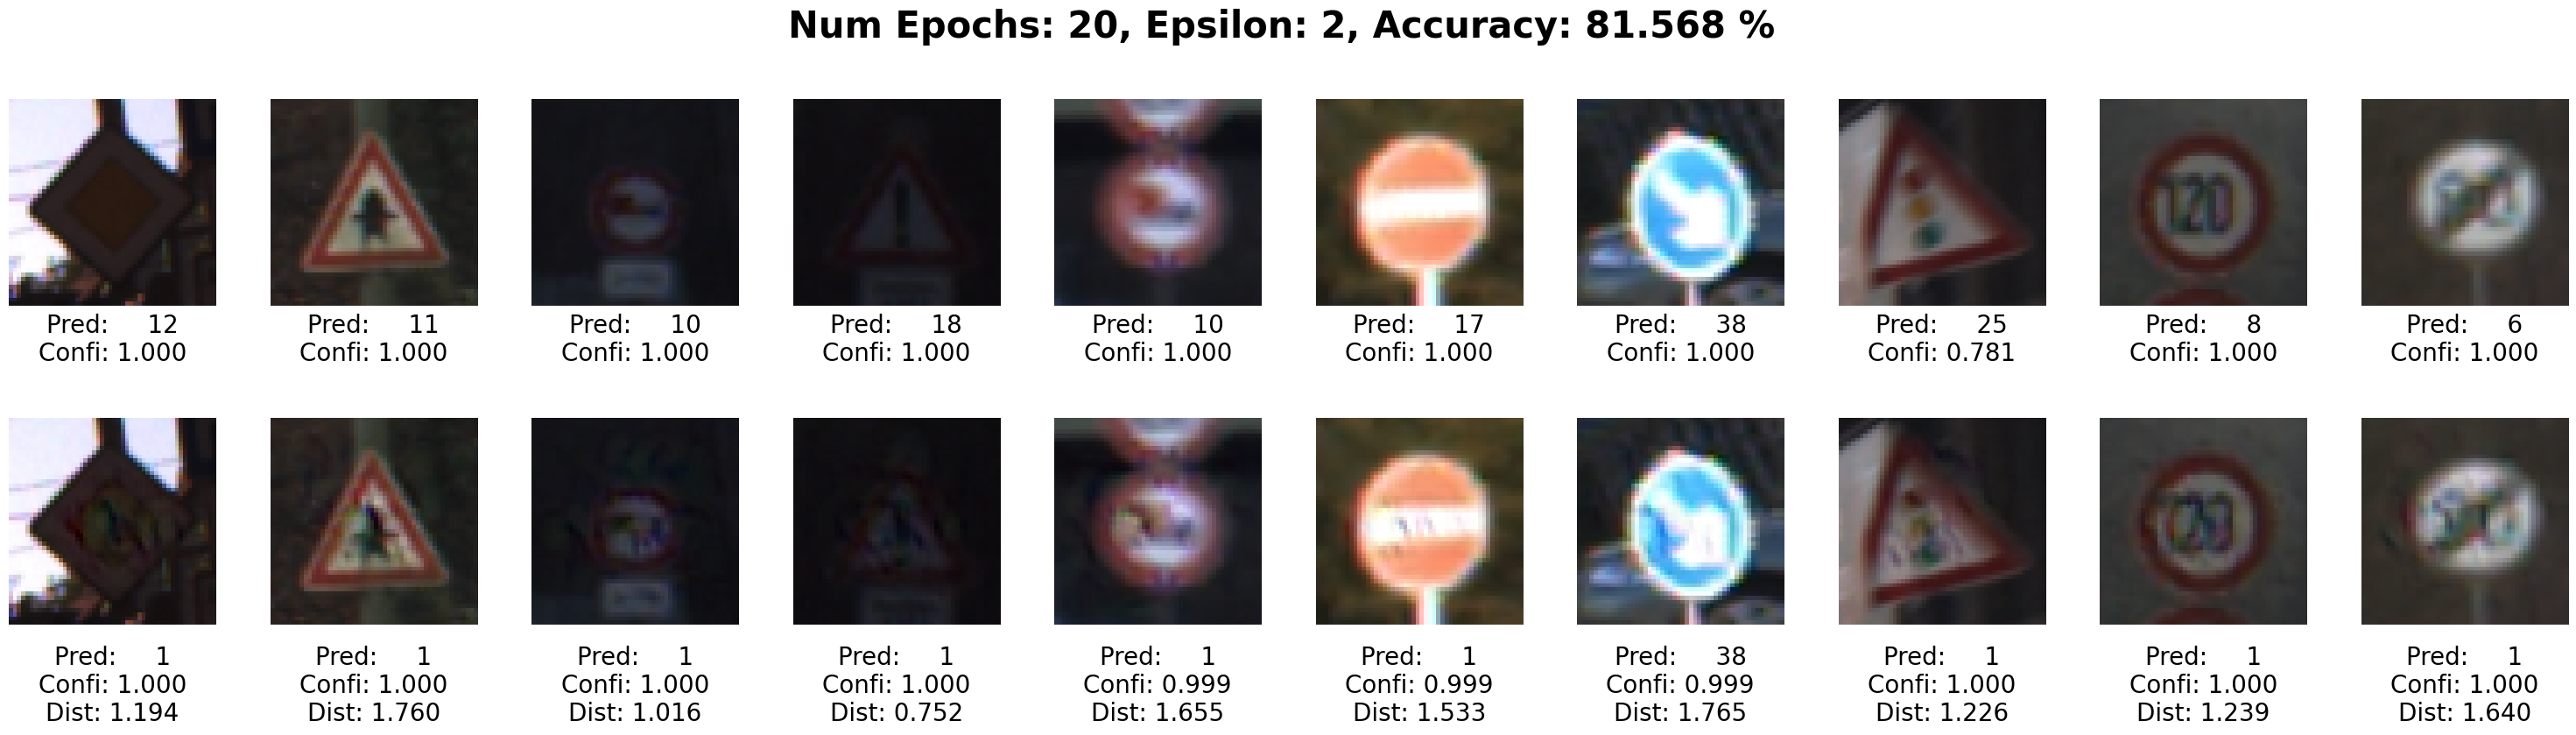

Progress: 100%|████████| 12630/12630 [29:37<00:00,  7.11it/s]
Test Accuracy : 0.9920031670625495 : 100%|█| 12630/12630 [01:


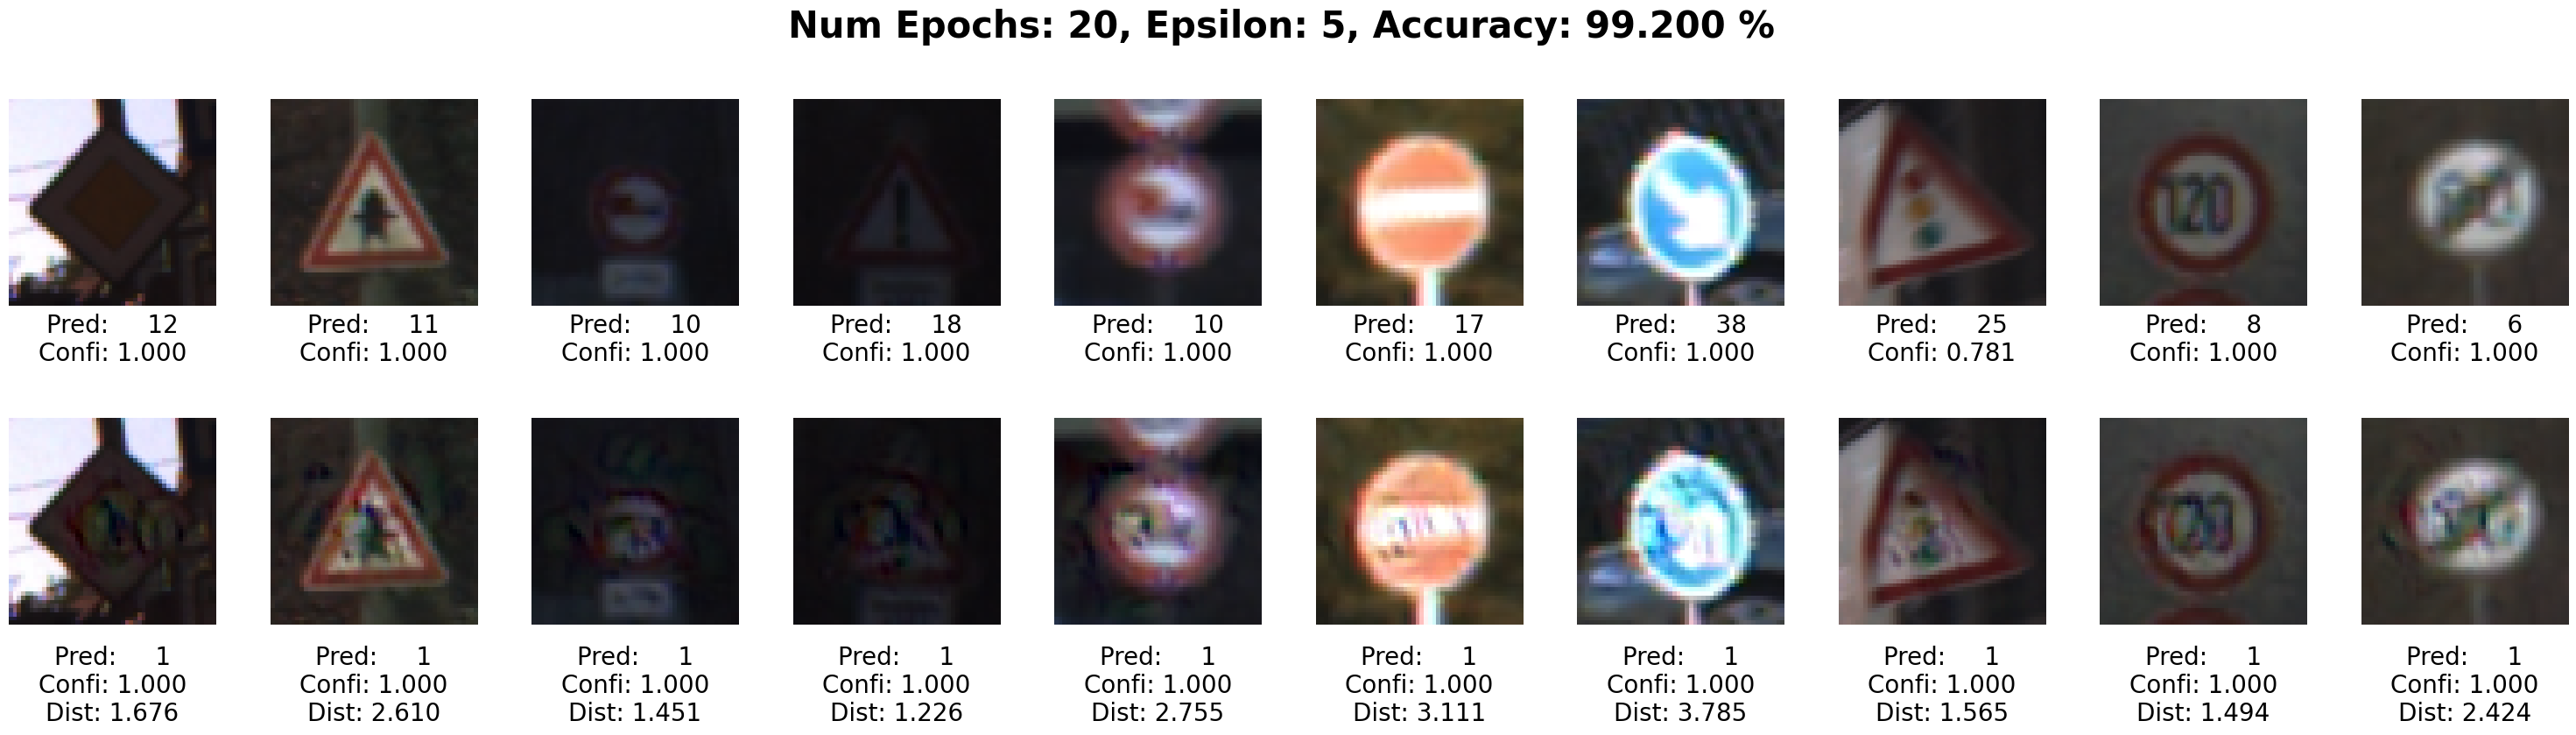

In [19]:
class CustomOptimizer(torch.optim.Optimizer): 
    # Init Method: 
    def __init__(self, params, lr=1e-3): 
        super(CustomOptimizer, self).__init__(params, defaults={'lr': lr}) 
        self.state = dict() 

    # Step Method 
    def step(self):
        # print(self.param_groups)
        for group in self.param_groups: 
            for p in group['params']: 
                # print(p.grad.data / p.grad.data.norm())
                p.data -= group['lr'] * p.grad.data / p.grad.data.norm()
                p.data = p.data.clamp(0,1)

def generate_adversarial_dataset_fgsm_multistep_targeted(model, device, test_loader,epsilon,num_epochs=100,target=torch.tensor([1])):
    adv_examples = []

    with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
        # Loop over all examples in test set
        target = target.to(device)
        for data, _ in test_loader:
            data = data.to(device)
            data.requires_grad = True
            # epsilon = epsilon/num_epochs
            optimizer = CustomOptimizer([data],lr=epsilon/num_epochs)
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if init_pred.item() != target.item():
                for epoch in range(num_epochs):
                    output = model(data)
                    optimizer.zero_grad()
                    loss = F.nll_loss(output, target)
                    loss.backward()
                    optimizer.step()
                adv_ex = data.clamp(0,1).squeeze().detach().cpu()
            else:
                adv_ex = data.squeeze().detach().cpu()
            adv_examples.append((adv_ex, target))
            progress.desc = f'Progress: '
            progress.update(1)
    return adv_examples
    
fgsm_multistep_target_successrate = generate_results(epsilons_l2,model,generate_adversarial_dataset_fgsm_multistep_targeted,testdata,fn_args = {'num_epochs':20},dist_fn = lambda a,b : (a-b).norm().detach().item())

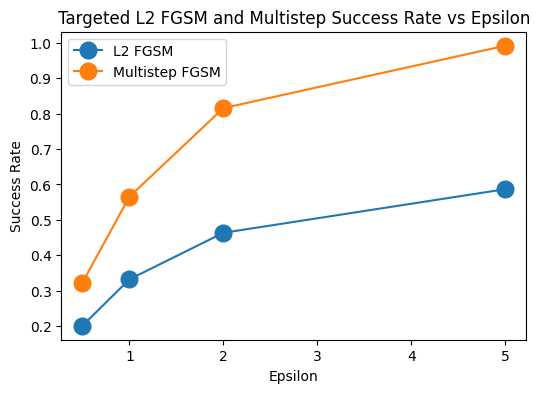

In [20]:
fig_target, ax_target = plt.subplots(figsize= (6, 4))
ax_target.plot(epsilons_l2, list(fgsm_l2_target_successrate.values()), marker='o', markersize=12, label="L2 FGSM")
ax_target.plot(epsilons_l2, list(fgsm_multistep_target_successrate.values()), marker='o', markersize=12, label="Multistep FGSM")
ax_target.set_xlabel("Epsilon")
ax_target.set_ylabel("Success Rate")
ax_target.set_title("Targeted L2 FGSM and Multistep Success Rate vs Epsilon")
ax_target.legend()
plt.show()

In [21]:
fgsm_multistep_successrate_epochs = {}
for e in epochs:
    fgsm_multistep_successrate_epochs[e] = generate_results(epsilons_l2,model,generate_adversarial_dataset_fgsm_multistep_targeted,testdata,fn_args = {'num_epochs':e},dist_fn = lambda a,b : (a-b).norm().detach().item(),show_results=False)
outfile = open('./pkl/accuracy_targeted_data.pkl','wb')
pickle.dump(fgsm_multistep_successrate_epochs,outfile)
outfile.close()

Progress: 100%|████████| 12630/12630 [04:05<00:00, 51.51it/s]
Test Accuracy : 0.266270783847981 : 100%|█| 12630/12630 [01:1
Progress: 100%|████████| 12630/12630 [04:02<00:00, 52.04it/s]
Test Accuracy : 0.47371338083927156 : 100%|█| 12630/12630 [01
Progress: 100%|████████| 12630/12630 [04:01<00:00, 52.20it/s]
Test Accuracy : 0.6858273950910531 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [04:01<00:00, 52.23it/s]
Test Accuracy : 0.9102137767220903 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [08:12<00:00, 25.66it/s]
Test Accuracy : 0.3053840063341251 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [08:12<00:00, 25.65it/s]
Test Accuracy : 0.5409342834520982 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [08:06<00:00, 25.96it/s]
Test Accuracy : 0.7793349168646081 : 100%|█| 12630/12630 [01:
Progress: 100%|████████| 12630/12630 [08:56<00:00, 23.55it/s]
Test Accuracy : 0.9790973871733967 : 100%|█| 12630/12630 [01:
Progress

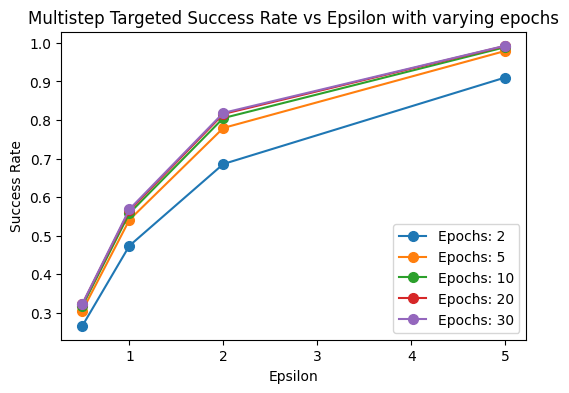

In [22]:
fig_target_epochs, ax_target_epochs = plt.subplots(figsize= (6, 4))
for e in epochs:
    ax_target_epochs.plot(epsilons_l2, list(fgsm_multistep_successrate_epochs[e].values()), marker='o', markersize=7, label=f"Epochs: {e}")
ax_target_epochs.set_xlabel("Epsilon")
ax_target_epochs.set_ylabel("Success Rate")
ax_target_epochs.set_title("Multistep Targeted Success Rate vs Epsilon with varying epochs")
ax_target_epochs.legend()
plt.show()